### Reweighting simulation endstates with fancy NN potentials
##### Josh+Marcus+Hannah+dom

In [1]:
import numpy as np
from netCDF4 import Dataset
import os

from simtk import unit, openmm
from openmmtools import integrators
from pymbar import EXP
from openmmtools.constants import kB
temperature = 298 * unit.kelvin
kBT = kB * temperature

import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# ANI imports
import torchani
import torch
model = torchani.models.ANI1ccx()

import mdtraj as md

from tqdm import tqdm
import random
import networkx as nx
%matplotlib inline

In [2]:
def compute_ani_energy(element_string, samples):
    # adapted from J.Fass code
    species = model.species_to_tensor(element_string).unsqueeze(0)
    coordinates = torch.tensor([sample * 10 for sample in samples], dtype=torch.float32) # converting nm to Angstrom
    energy = model((torch.stack([species[0]] * len(samples)), coordinates))
    return energy.energies.detach().numpy() * 627.5 #* unit.kilojoule_per_mole # convert from hartree to kJ/mol

def plot_mm_vs_ani(MM, ANI,title='',color='grey'):
    grid = sns.JointGrid(MM,ANI,space=0, height=6, ratio=5)
    grid.plot_joint(sns.scatterplot, color=color, alpha=0.5)
    plt.xlabel(f'MM energies / kJ/mol',weight='semibold')
    plt.ylabel(f'ANI energies / kJ/mol',weight='semibold')
    grid.plot_marginals(sns.kdeplot, shade=True, color=color)
    
    # TODO add much better stats, with error bars
    _, _, r_value, _, _ = scipy.stats.linregress(MM,ANI)

    title = title +r'$R^2$ = '+f'{r_value**2:.2f}'
    ### adding standard deviation labels to marginals
    range_x = (grid.ax_marg_x.dataLim.x0 + grid.ax_marg_x.dataLim.x1)
    mid_x = (range_x)/ 2
    range_y = (grid.ax_marg_y.dataLim.y0 + grid.ax_marg_y.dataLim.y1)
    mid_y = range_y / 2
    grid.ax_marg_x.text(mid_x,grid.ax_marg_x.dataLim.y1*0.2,f'std: {np.std(MM):.1f}',weight='semibold')
    grid.ax_marg_y.text(grid.ax_marg_y.dataLim.x1*0.2,mid_y,f'std: {np.std(ANI):.1f}',weight='semibold')

    #title
    grid.ax_marg_x.text(mid_x,grid.ax_marg_x.dataLim.y1,title,horizontalalignment='center')

    plt.show()

def calculate_correction(MM, ANI,bootstrap=100):
    reduced_works = (MM - ANI) / kBT
    result = EXP(reduced_works)
    return result[0] * kBT, result[1] * kBT 

def show_perturbation(folder):
    # try to open the perturbation image
    try:
        from IPython.display import display, Image
        i = Image(filename=f'/Users/brucemah/bin/nn-endstates/data/jnk1April/{folder}/atom_mapping.png')
        display(i)
    except:
        print('Can\'t open image')

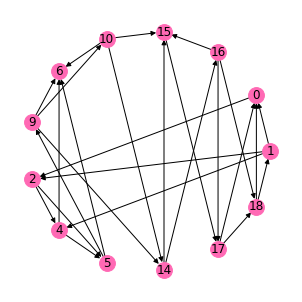

In [7]:
ani_compatible = [0, 1, 2, 4, 5, 6, 9, 10, 14, 15, 16, 17, 18]

# ligand_pairs = []
# for i,j in enumerate(ani_compatible):
#     if len(ani_compatible) < i:
#         ligand_pairs.append((j,ani_compatible[i+1]))
#     else:
#         ligand_pairs.append((j,ani_compatible[i-len(ani_compatible)+1]))
#     if len(ani_compatible) < i+1:
#         ligand_pairs.append((j,ani_compatible[i+2]))
#     else:
#         ligand_pairs.append((j,ani_compatible[i-len(ani_compatible)+2]))
ligand_pairs = [(1,0), (16,15), (10,6), (9,6), (0, 2), (1, 2), (1, 4), (2, 4), (2, 5), (4, 5), (4, 6), (5, 6), (5, 9), (9, 10), (9, 14), (10, 14), (10, 15), (14, 15), (14, 16), (15, 17), (16, 17), (16, 18), (17, 18), (17, 0), (18, 0), (18, 1)]        
        
G = nx.DiGraph()

for i,j in ligand_pairs:
    G.add_edge(i,j)
    
    
plt.figure(figsize=(4,4))
nx.draw_circular(G,node_color='hotpink', node_size=250,labels={i:i for i in G.nodes()})
plt.show()

for node in G.nodes():
    # start with empty dict
    G.nodes[node]['results'] = {}

In [49]:
print(len(ani_compatible))

13


Getting data for edge 1 to 0


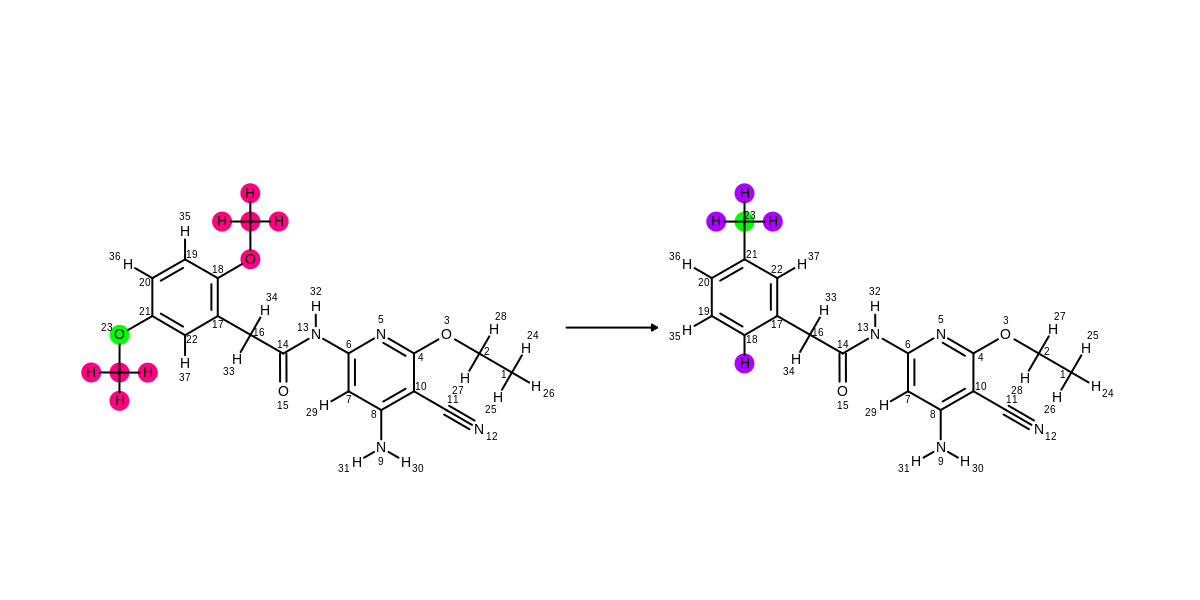

No context for ligand 1 stored yet - loading one from edge (1, 0)
No context for ligand 0 stored yet - loading one from edge (1, 0)
Getting data for edge 1 to 2


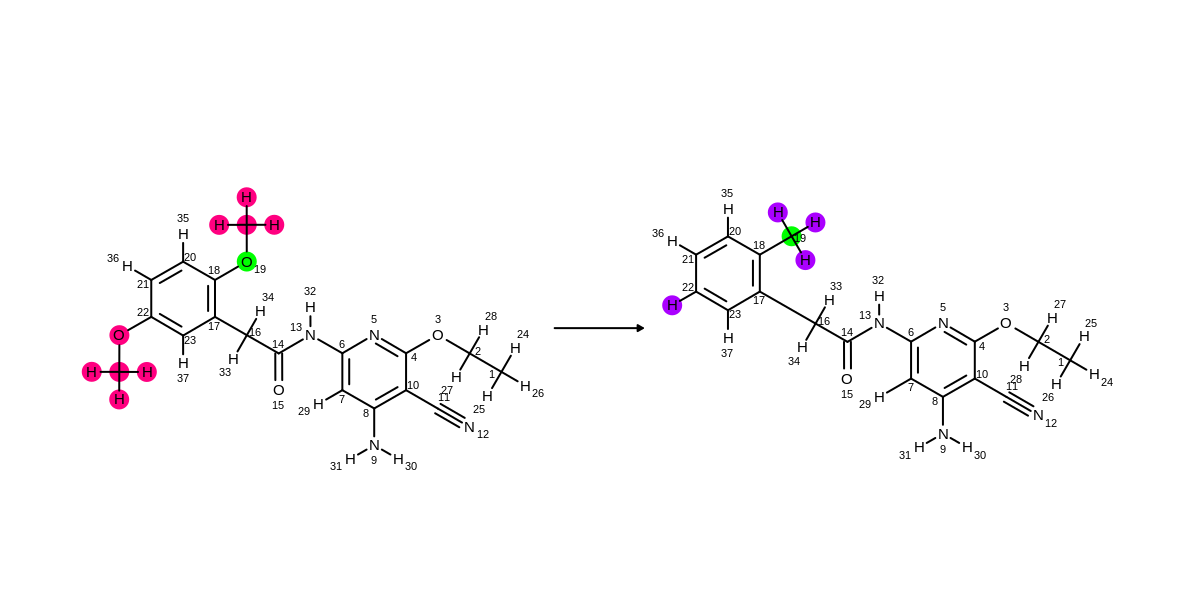

No context for ligand 2 stored yet - loading one from edge (1, 2)
Getting data for edge 1 to 4


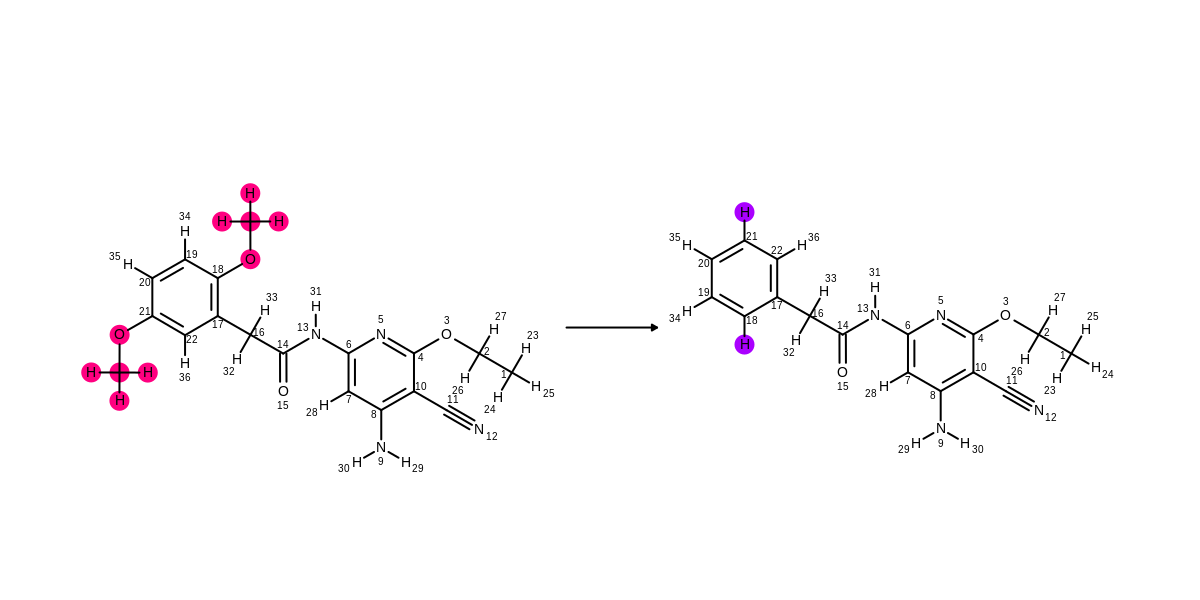

No context for ligand 4 stored yet - loading one from edge (1, 4)
Getting data for edge 0 to 2


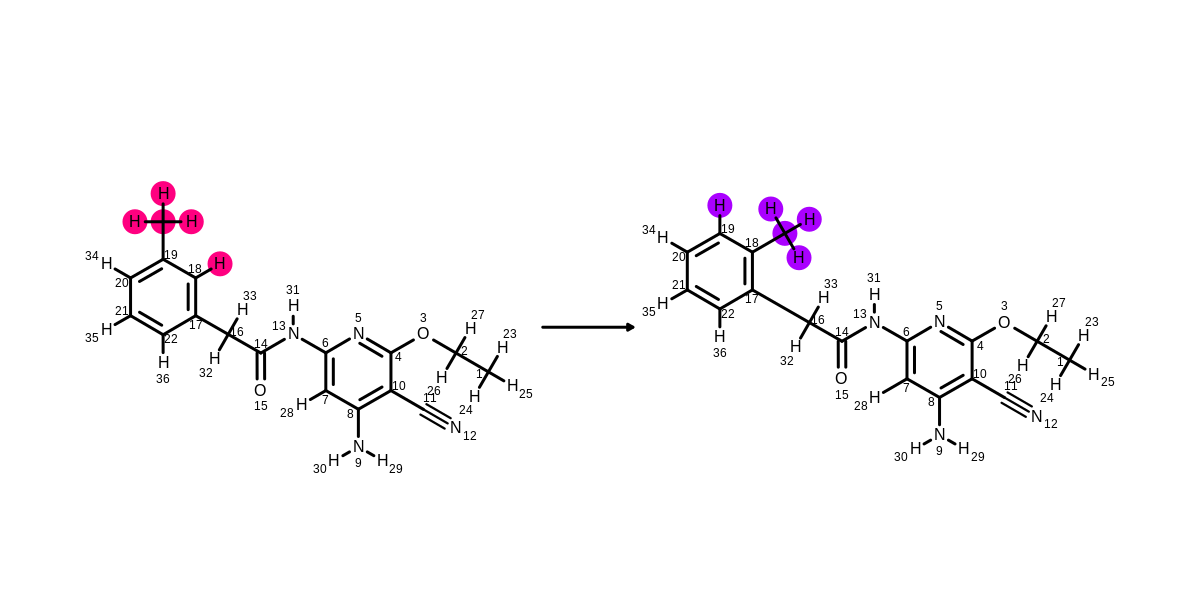

Getting data for edge 16 to 15


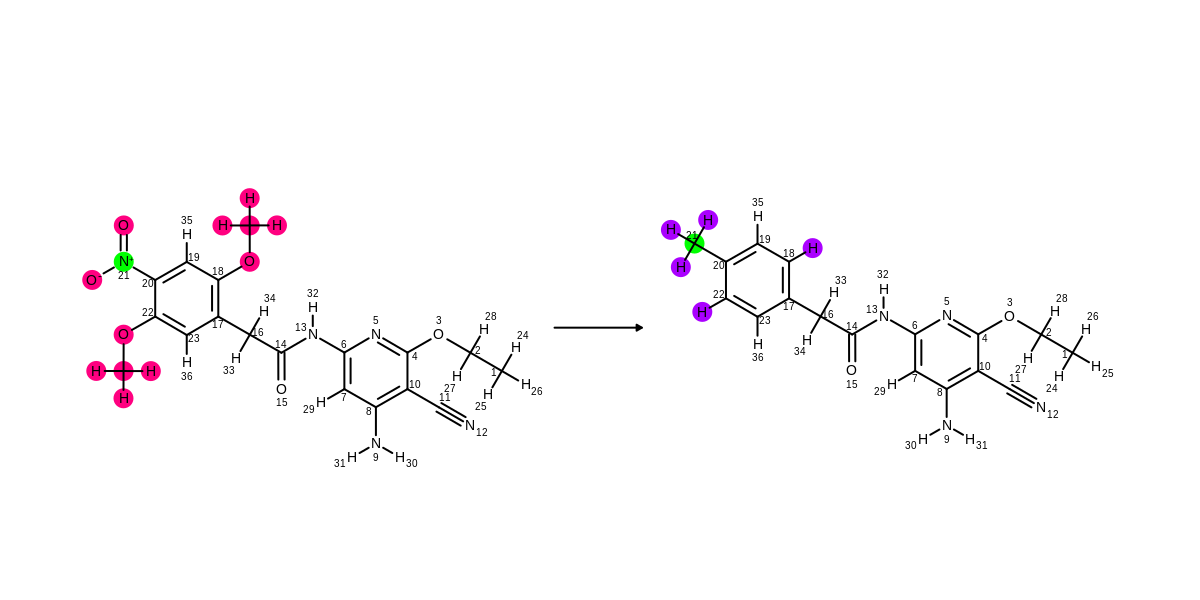

No context for ligand 16 stored yet - loading one from edge (16, 15)
No context for ligand 15 stored yet - loading one from edge (16, 15)
Getting data for edge 16 to 17


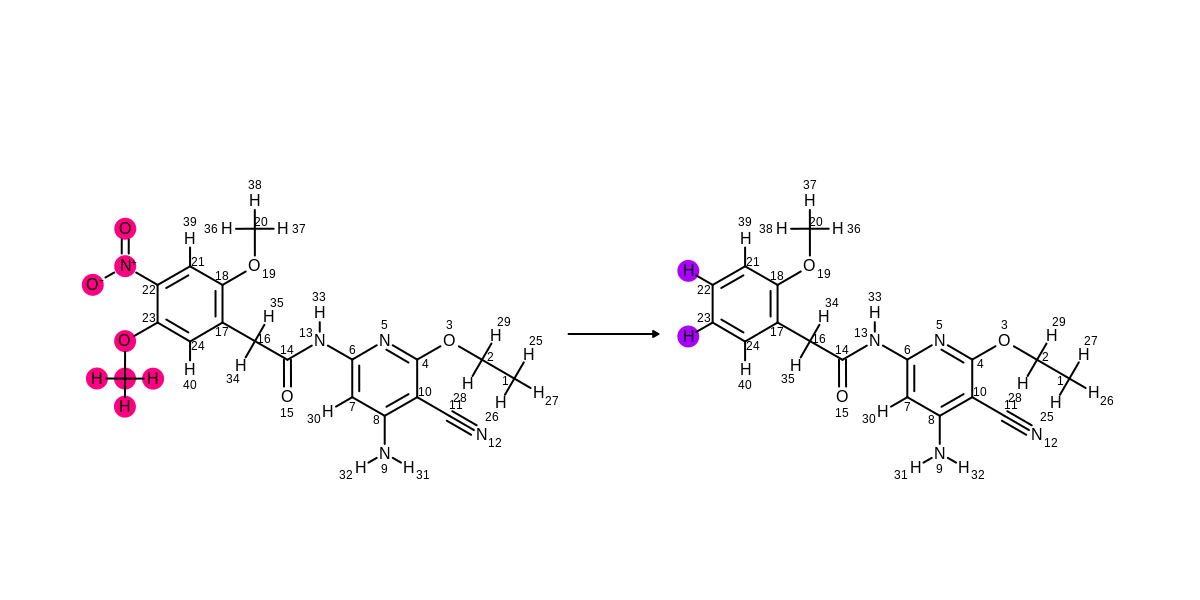

No context for ligand 17 stored yet - loading one from edge (16, 17)
Getting data for edge 16 to 18


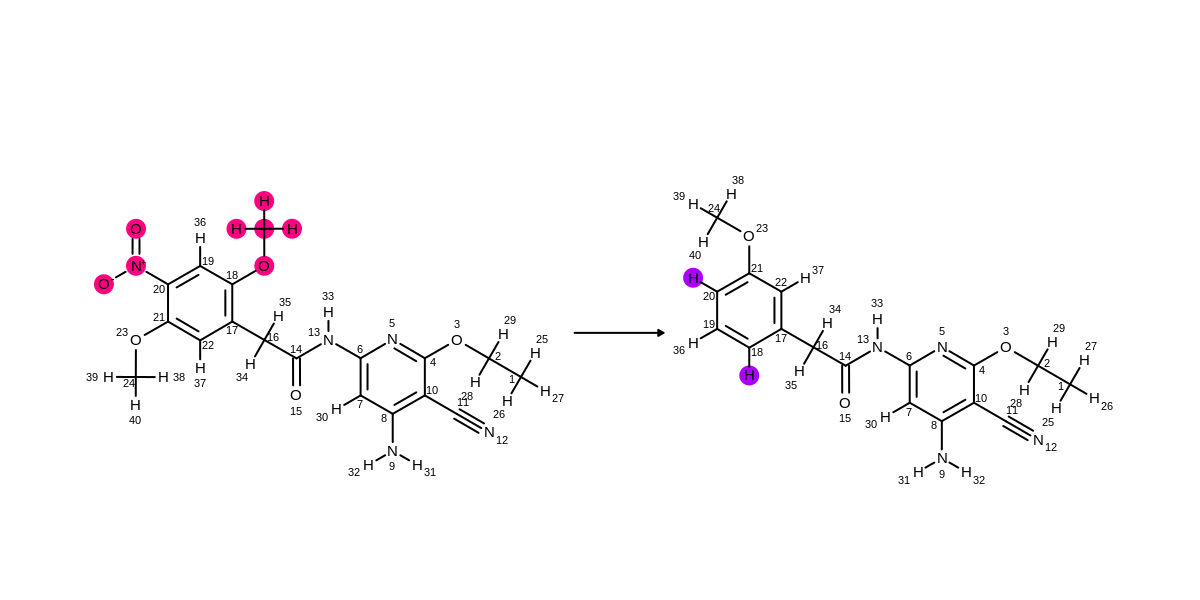

No context for ligand 18 stored yet - loading one from edge (16, 18)
Getting data for edge 15 to 17


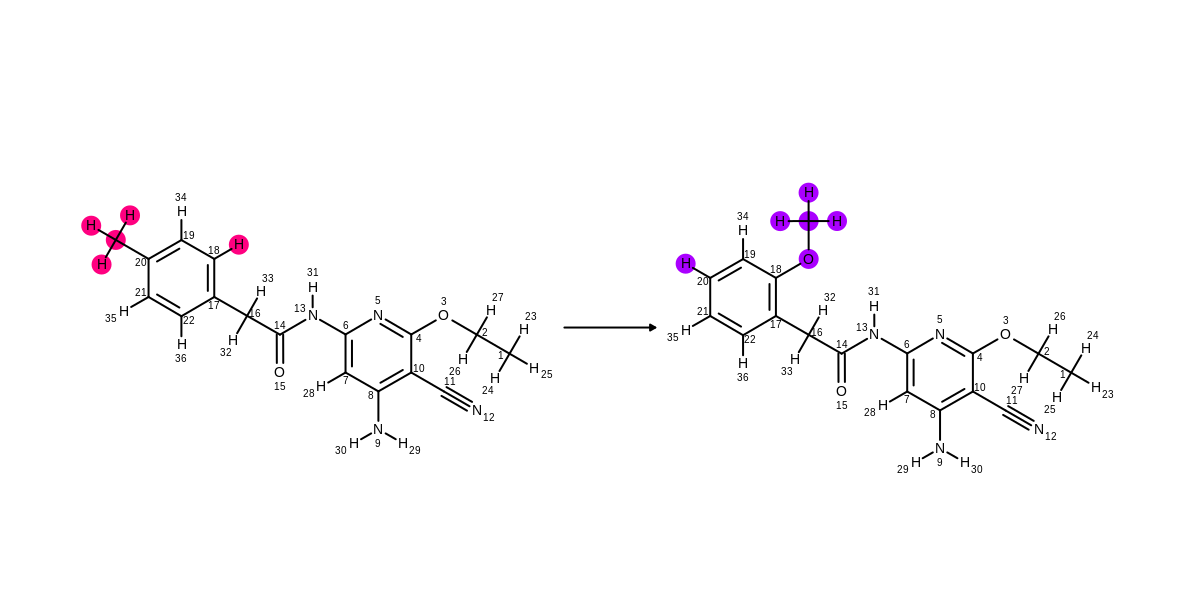

Getting data for edge 10 to 6


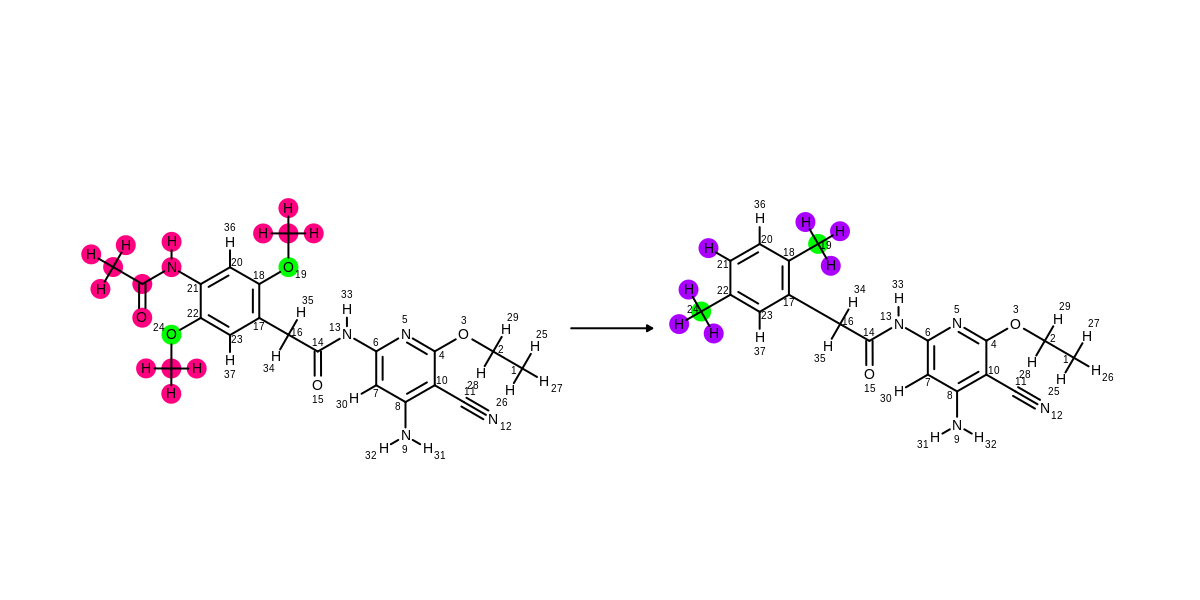

No context for ligand 10 stored yet - loading one from edge (10, 6)
No context for ligand 6 stored yet - loading one from edge (10, 6)
Getting data for edge 10 to 14


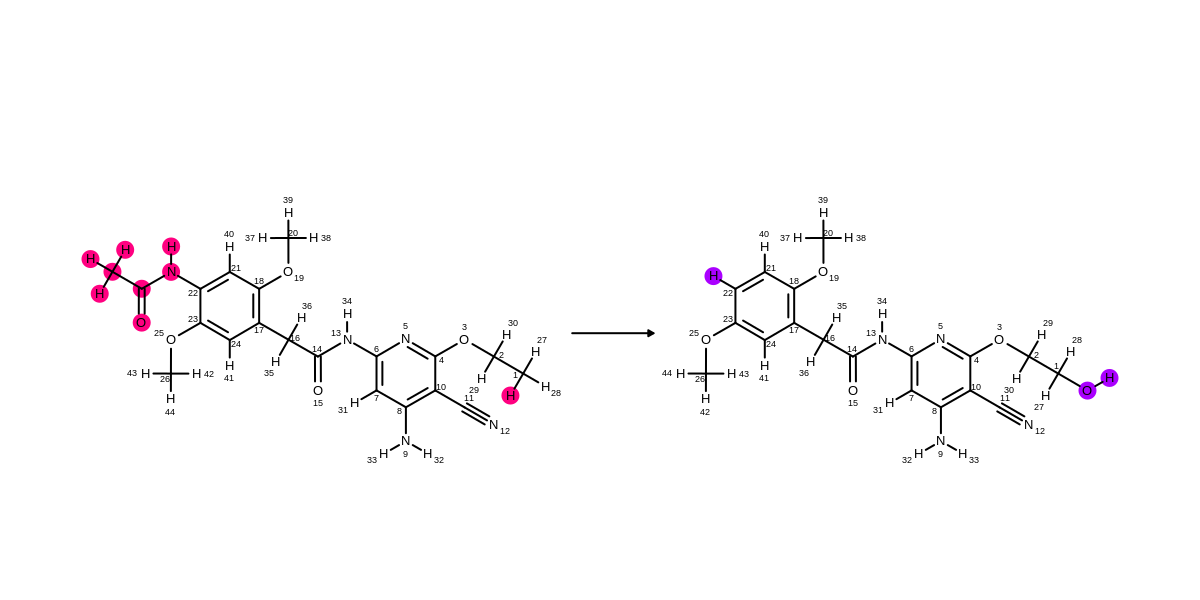

No context for ligand 14 stored yet - loading one from edge (10, 14)
Getting data for edge 10 to 15


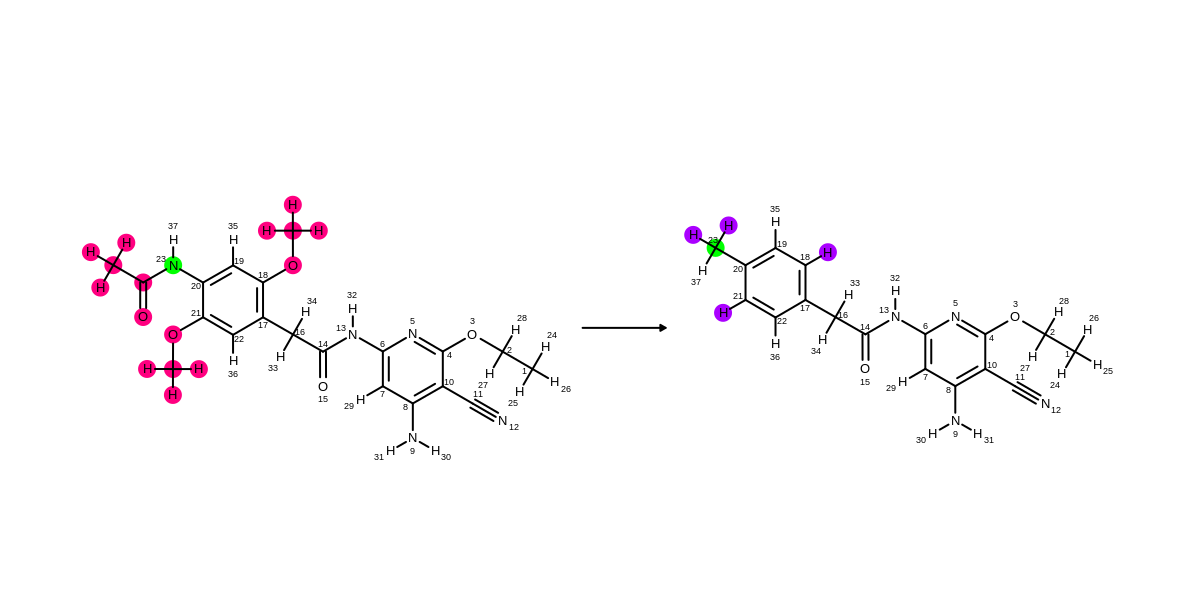

Getting data for edge 9 to 6


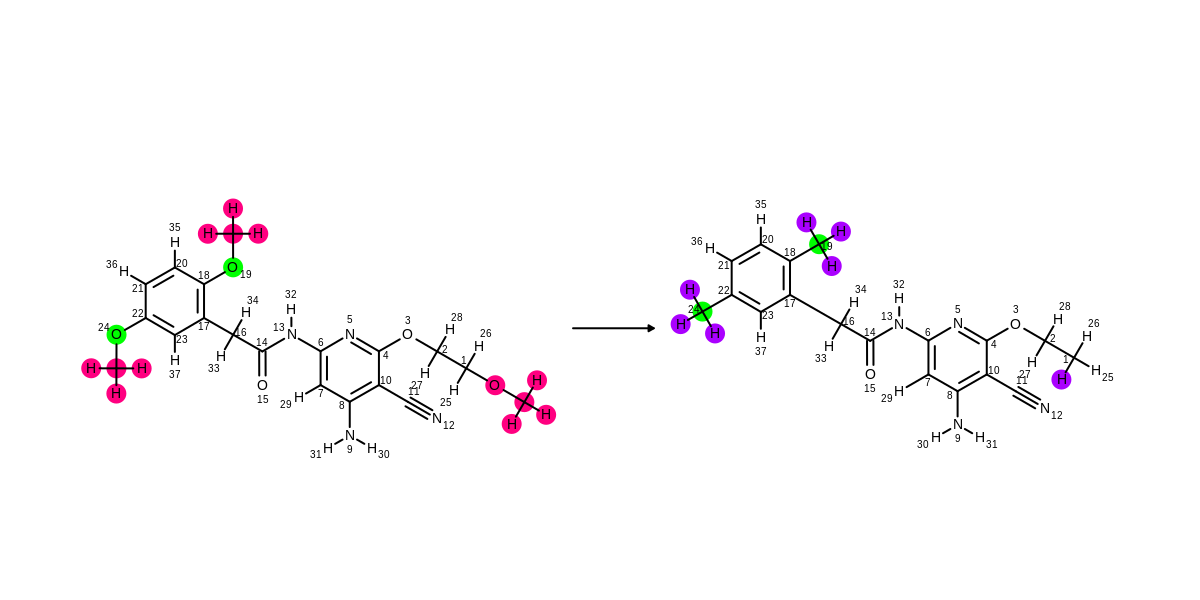

No context for ligand 9 stored yet - loading one from edge (9, 6)
Getting data for edge 9 to 10


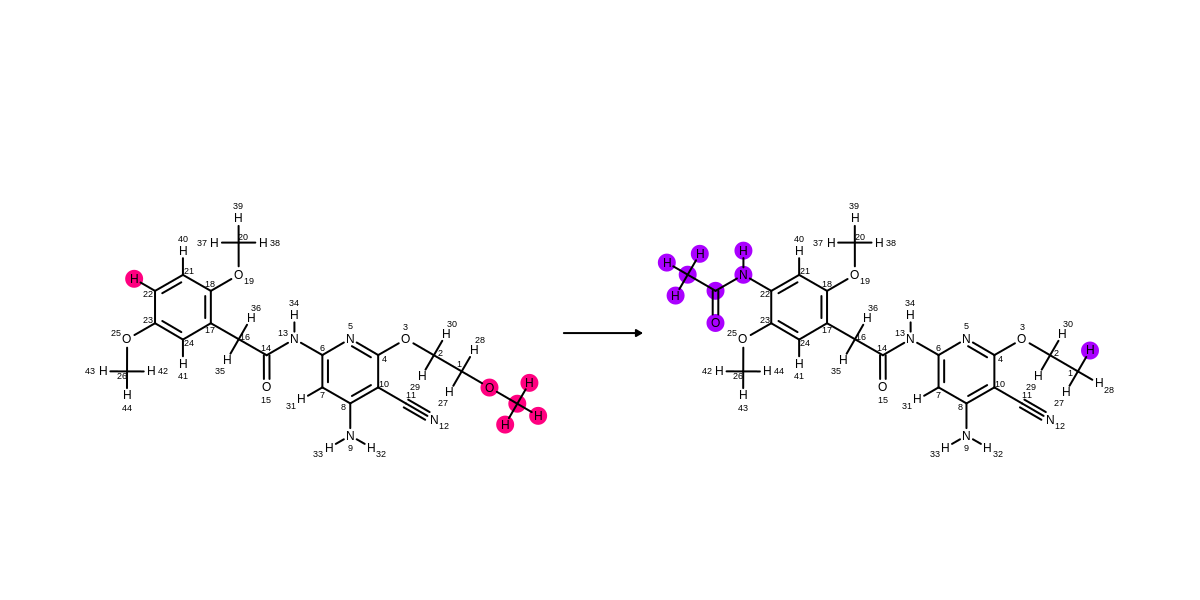

Getting data for edge 9 to 14


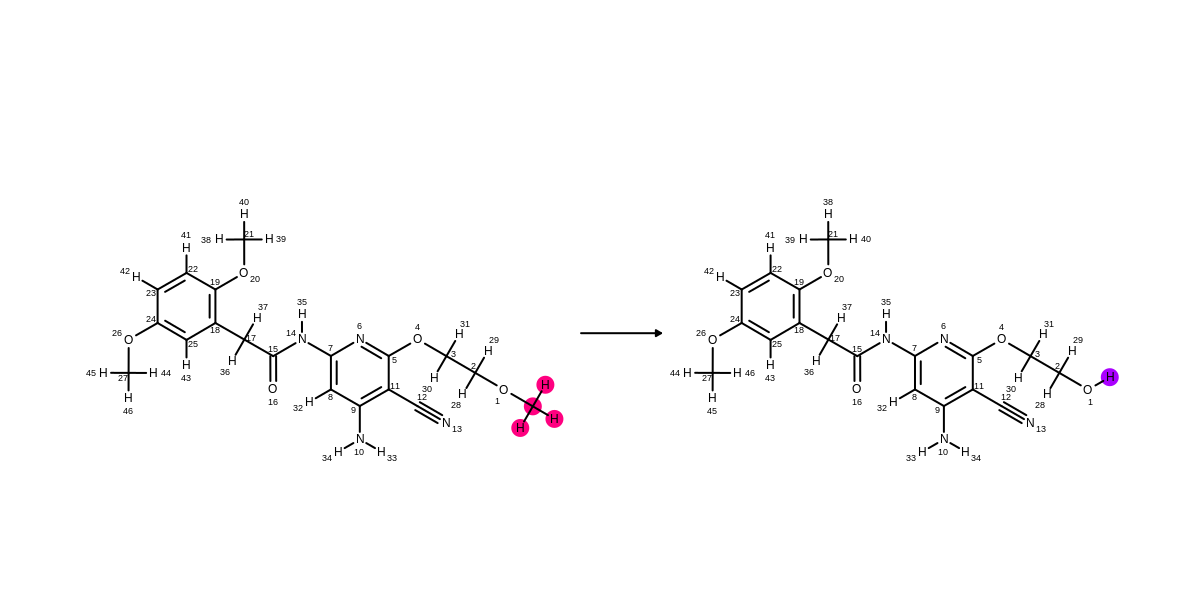

Getting data for edge 2 to 4


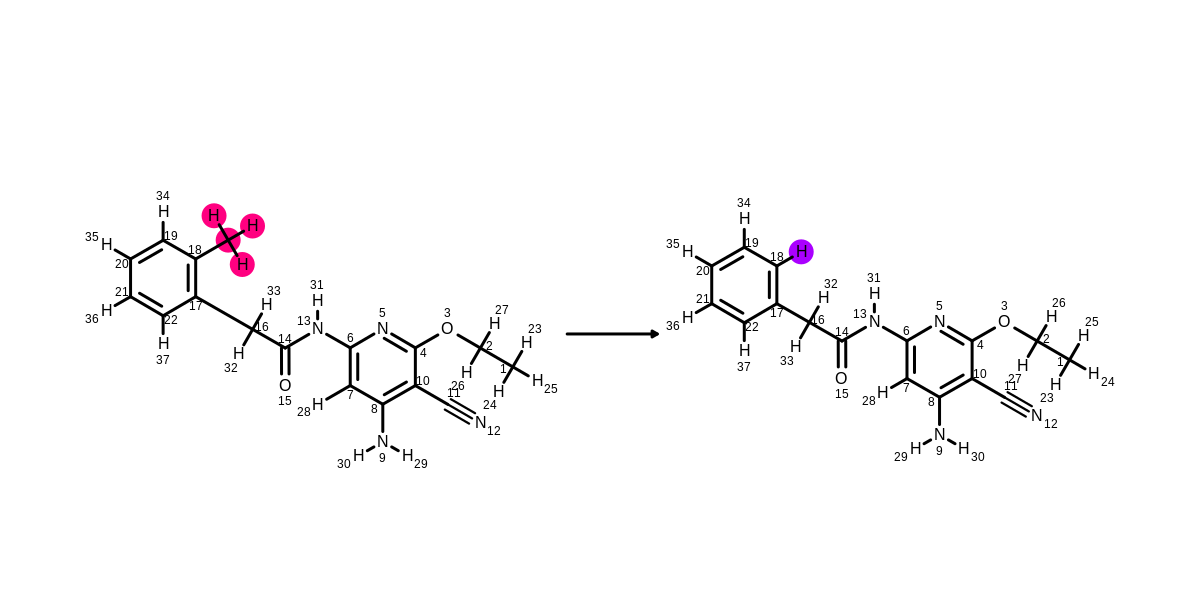

Getting data for edge 2 to 5


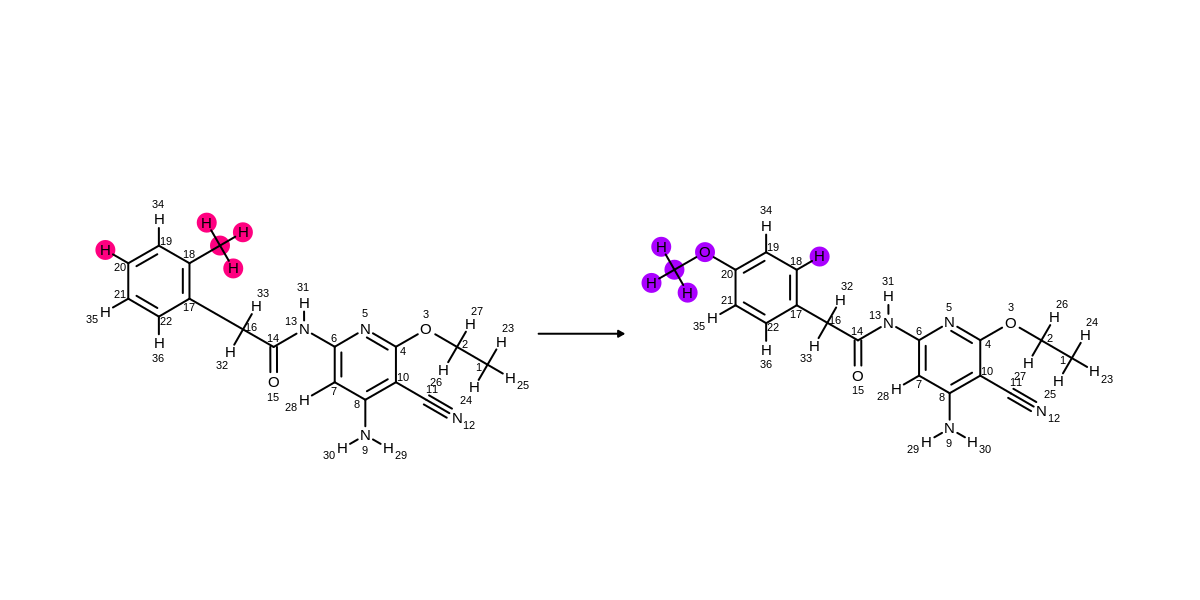

No context for ligand 5 stored yet - loading one from edge (2, 5)
Getting data for edge 4 to 5


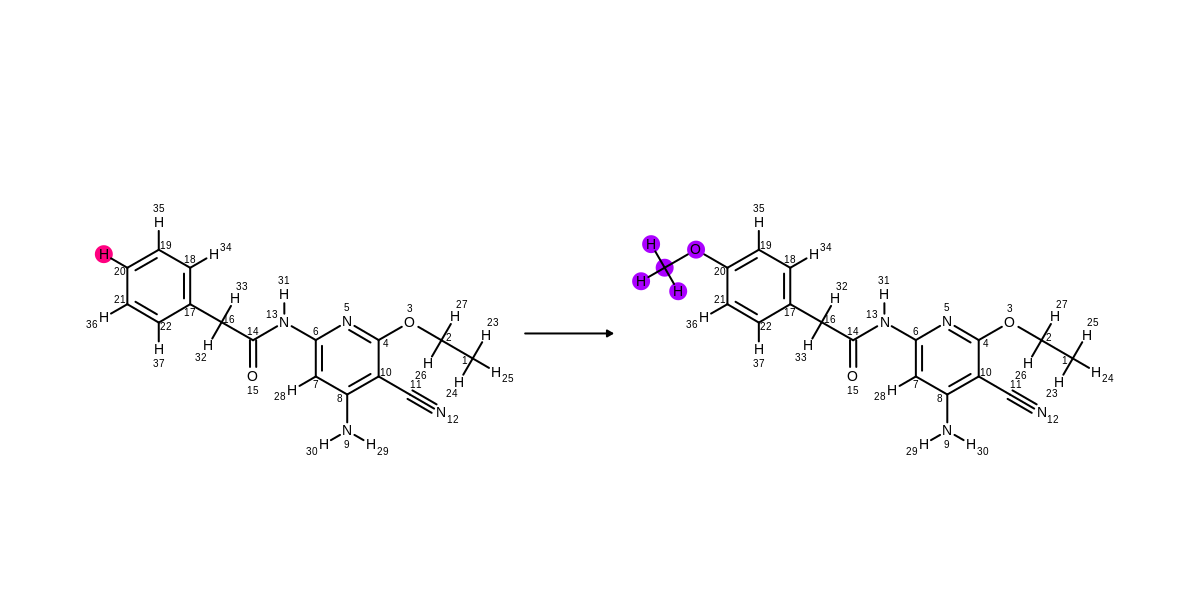

Getting data for edge 4 to 6


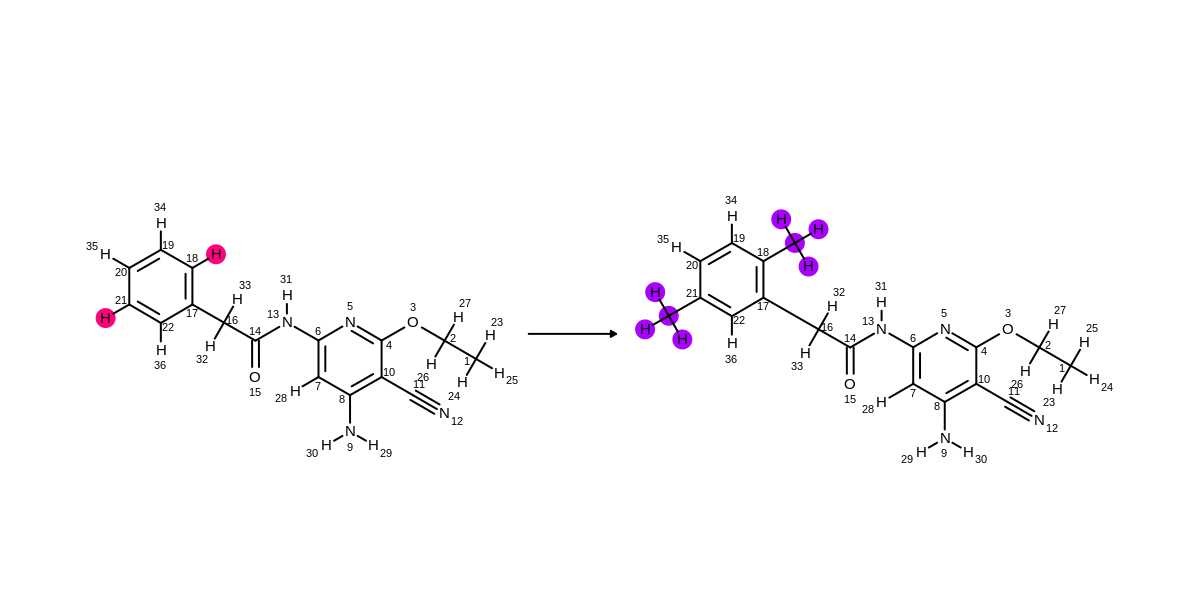

Getting data for edge 5 to 6


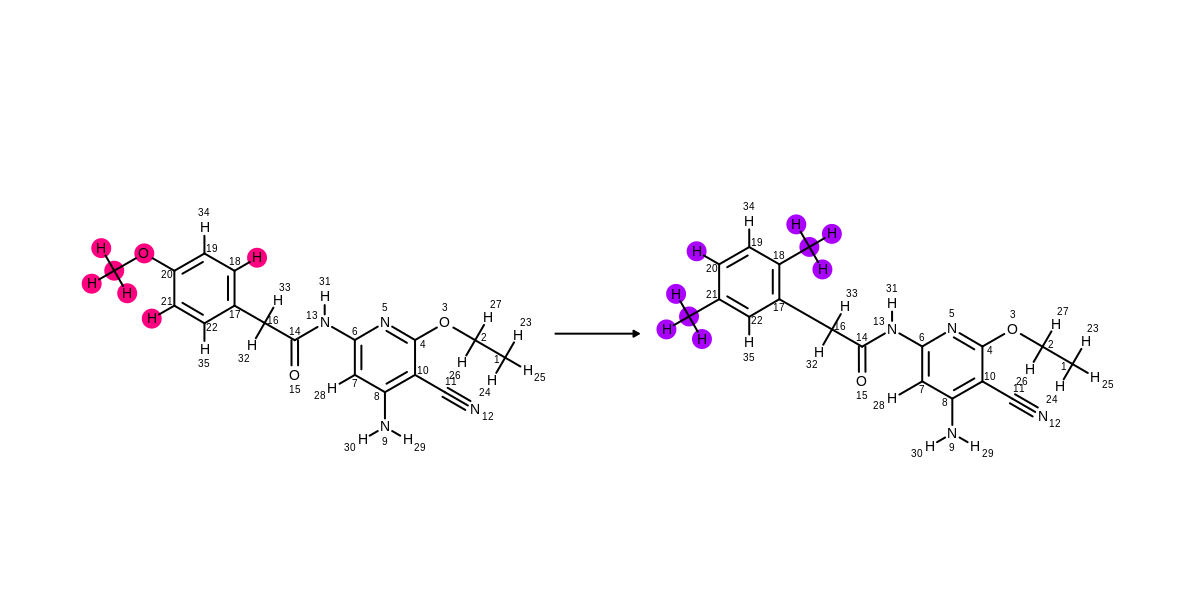

Getting data for edge 5 to 9


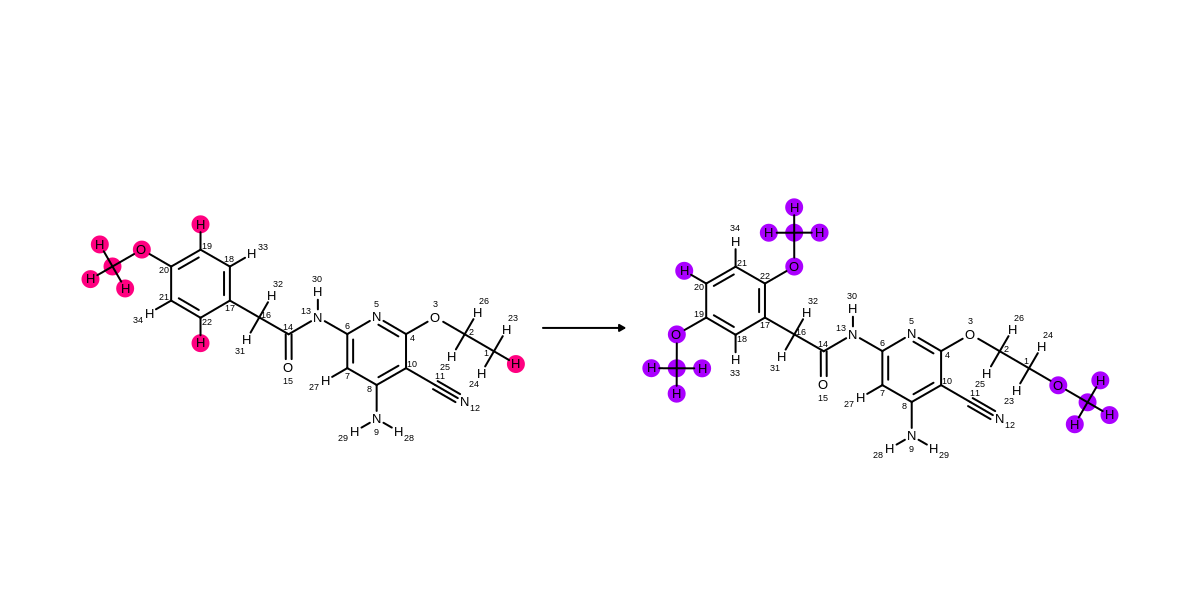

Getting data for edge 14 to 15


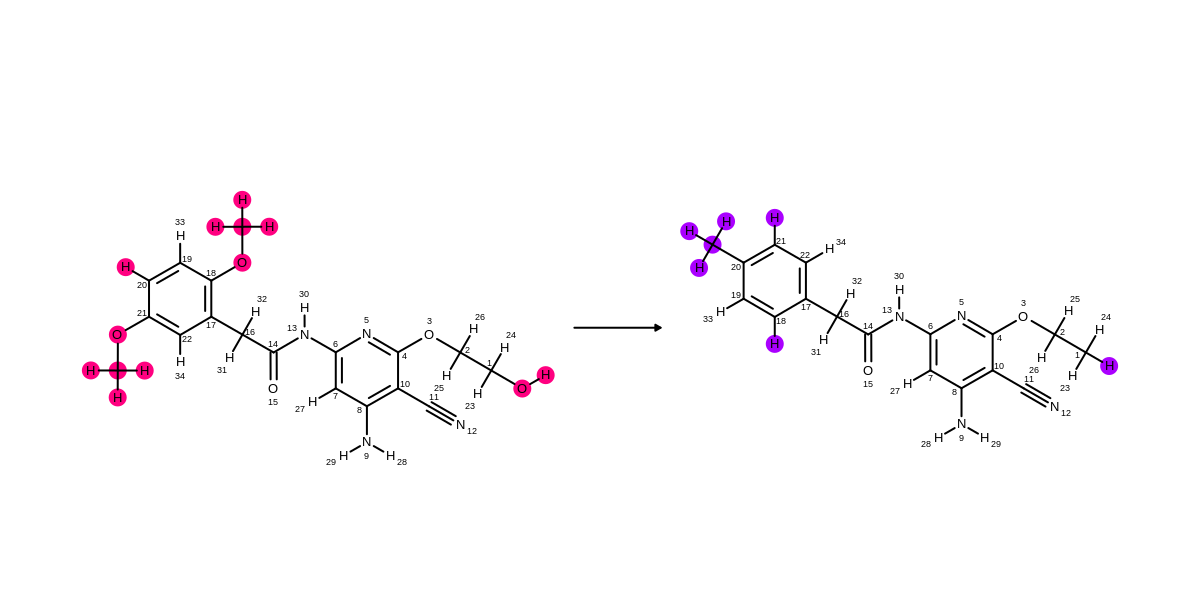

Getting data for edge 14 to 16


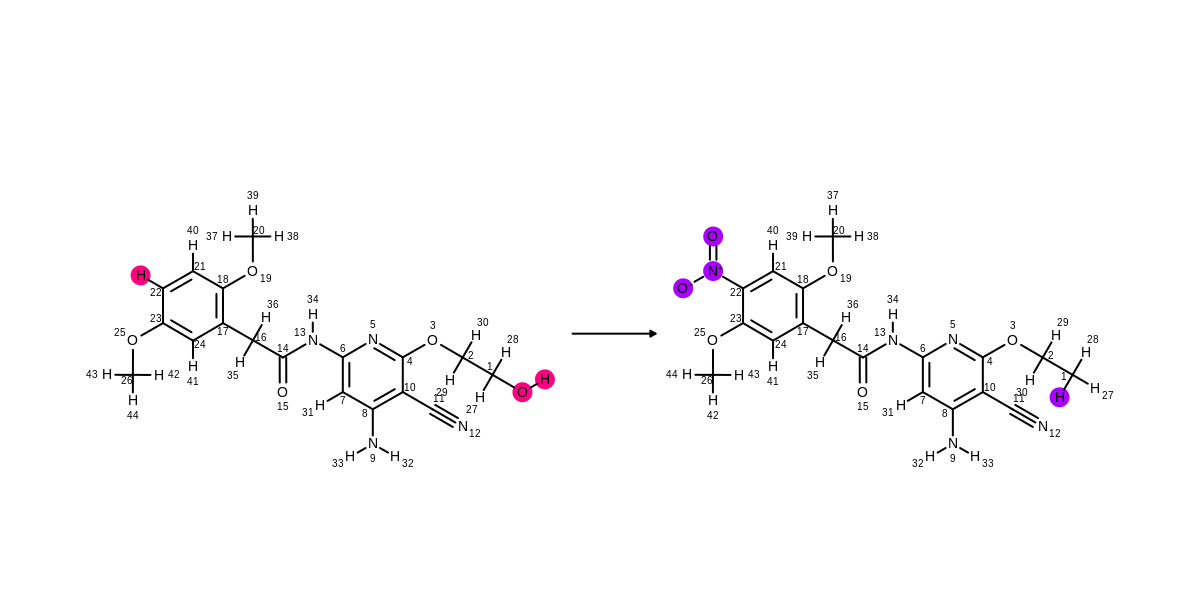

Getting data for edge 17 to 18


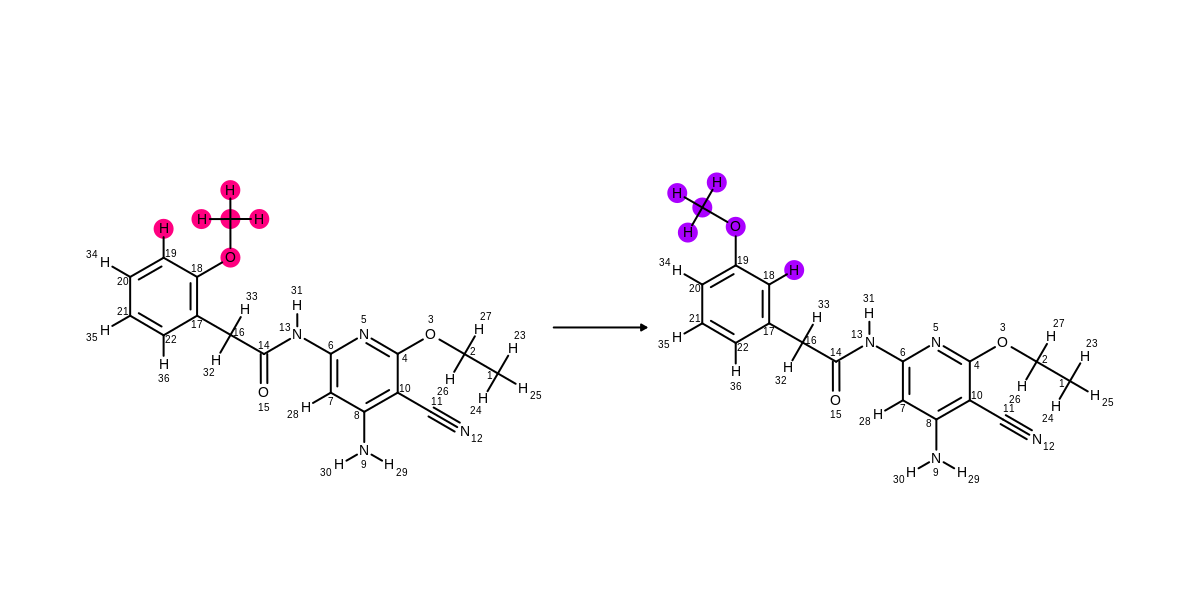

Getting data for edge 17 to 0


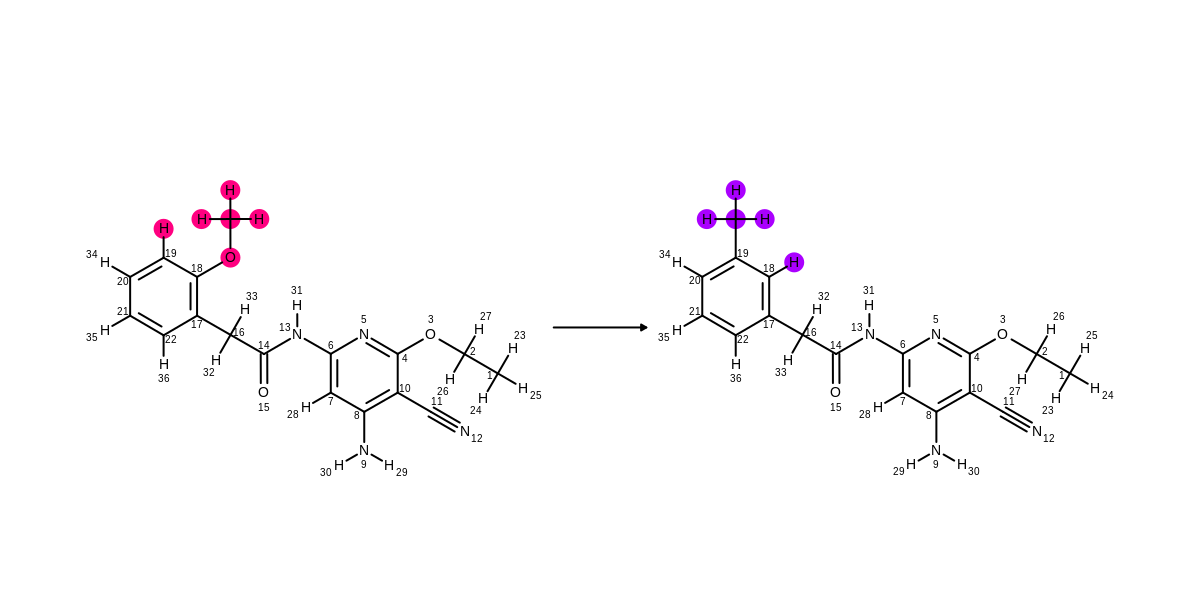

Getting data for edge 18 to 0


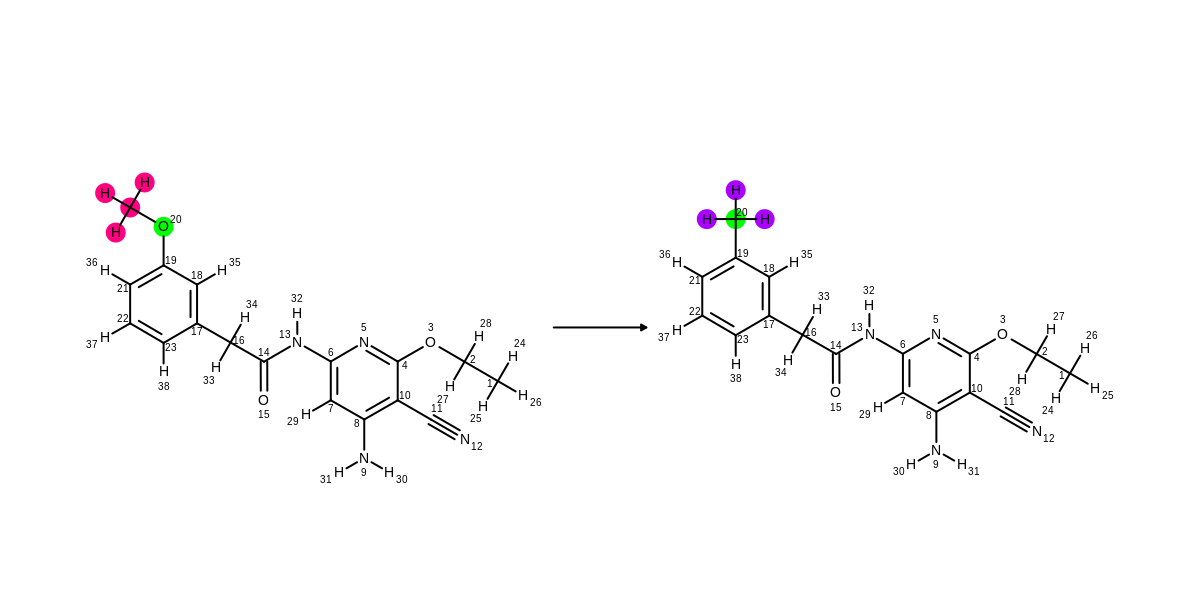

Getting data for edge 18 to 1


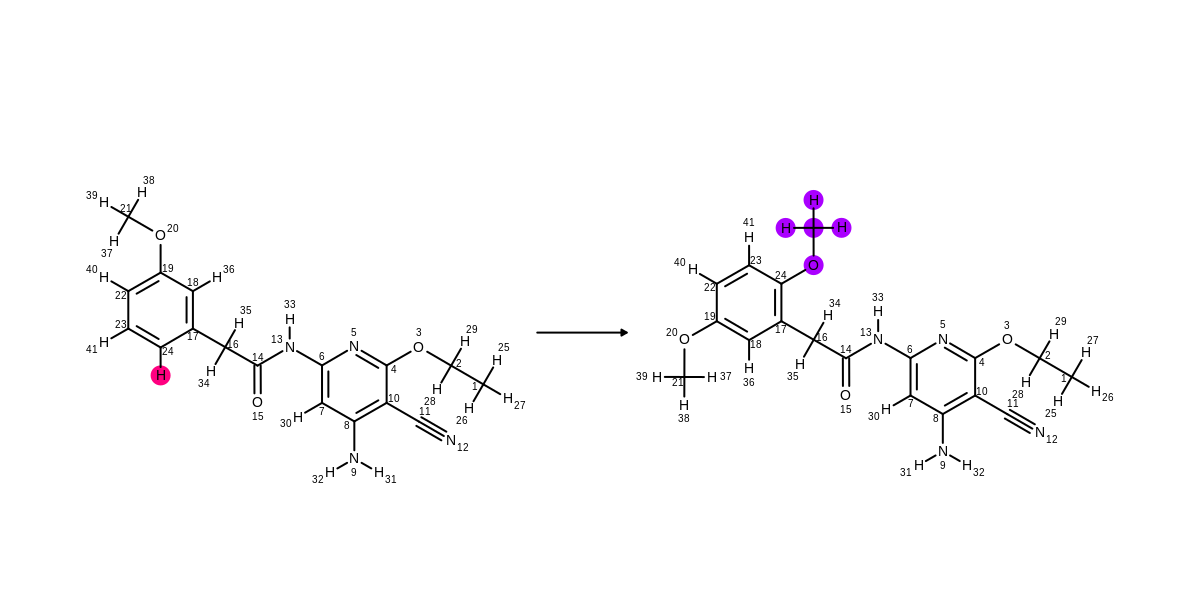

In [8]:
phases = ['complex','solvent','vacuum']

for a,b in G.edges():
    print(f'Getting data for edge {a} to {b}')
    folder = f'lig{a}to{b}'
    show_perturbation(folder)
    
    for i in (a,b):
        for phase in phases:
            try:
                positions = np.load(f'data/jnk1April/{folder}/positions_{str(i)}_{phase}.npy')
            except:
                print(f'No stored positions for edge {a,b} for ligand {i} for phase {phase}')
                continue

            # get the context from the node, or if it's not already got one - load one
            if 'context' not in G.nodes[i].keys():
                print(f'No context for ligand {i} stored yet - loading one from edge {a,b}')
                htf = np.load(f'data/jnk1April/{folder}/outhybrid_factory.npy',allow_pickle=True)
                htf = htf.flatten()[0]     
                if i == a:
                    # serialize each of the systems and write something to re-add the contexts to the nodes.
                    context = openmm.Context(htf['vacuum']._old_system, integrators.LangevinIntegrator())
                    element = ''.join([x.element.symbol for i, x in enumerate(htf['vacuum'].hybrid_topology.atoms) if i in htf['vacuum'].old_to_hybrid_atom_map.keys()])
                else:
                    context = openmm.Context(htf['vacuum']._new_system, integrators.LangevinIntegrator())
                    element = ''.join([x.element.symbol for i, x in enumerate(htf['vacuum'].hybrid_topology.atoms) if i in htf['vacuum'].new_to_hybrid_atom_map.keys()])
                G.nodes[i]['context'] = context
                G.nodes[i]['element_str'] = element
            else:
                context = G.nodes[i]['context']
            
            n_iterations, _, _ = np.shape(positions)
            
            MM_results = np.zeros(shape=n_iterations)
            ANI_results = np.zeros(shape=n_iterations)
            
            for j,pos in enumerate(positions):
                # MM energy
                context.setPositions(pos)
                result = context.getState(getEnergy=True).getPotentialEnergy()
                MM_results[j] = result / result.unit
            
            # try move this out of a loop
            ANI_results = compute_ani_energy(G.nodes[i]['element_str'], positions) [iterations, atoms, 3]
                
            # STORE THE RESULTS
            G.nodes[i]['results'][f'{folder}_{phase}_MM'] = MM_results
            G.nodes[i]['results'][f'{folder}_{phase}_ANI'] = ANI_results            

LIGAND 1
lig1to4
CORRECTION = -9.880557714379393 kcal/mol
ERROR: 1.0241816820655125 kcal/mol



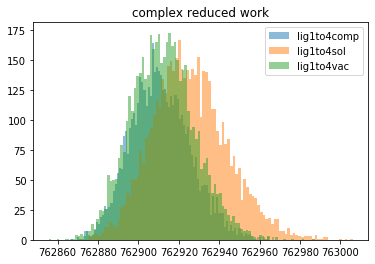

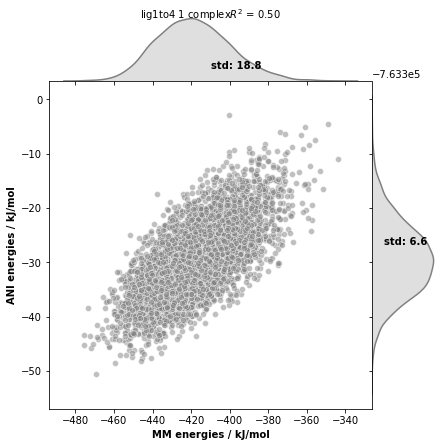

lig18to1
CORRECTION = -4.842533846269362 kcal/mol
ERROR: 1.1015846983487945 kcal/mol



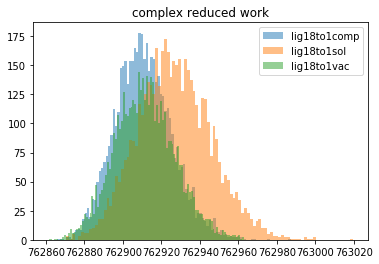

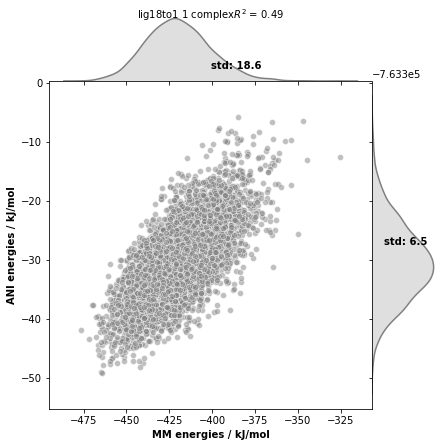

lig1to0
CORRECTION = -4.559904107009061 kcal/mol
ERROR: 0.860215396707175 kcal/mol



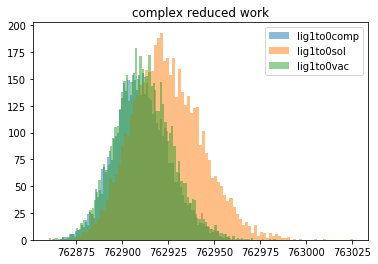

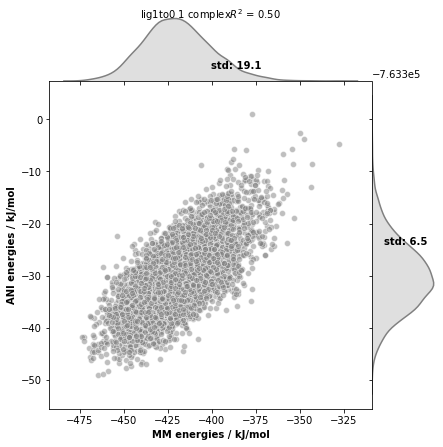

lig1to2
CORRECTION = -1.9834582571638748 kcal/mol
ERROR: 1.1048144552836952 kcal/mol



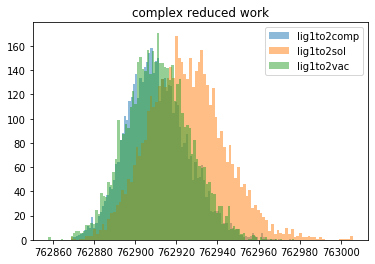

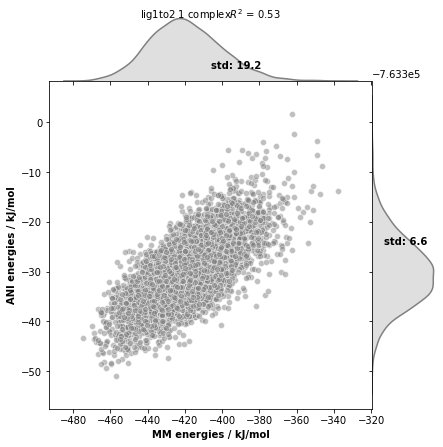


LIGAND 0
lig0to2
CORRECTION = -1.590909523773007 kcal/mol
ERROR: 1.030184410089397 kcal/mol



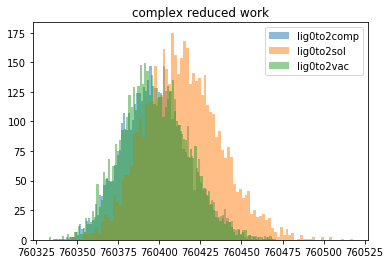

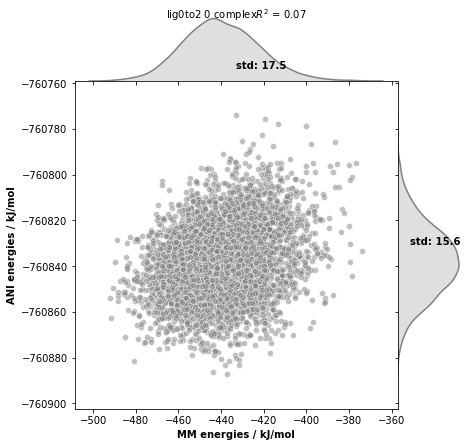

lig18to0
CORRECTION = 3.9810484738554806 kcal/mol
ERROR: 1.142724969687472 kcal/mol



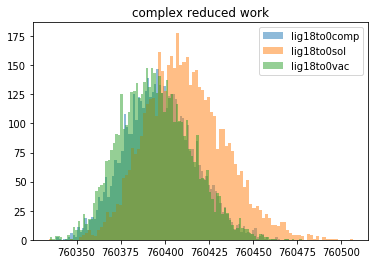

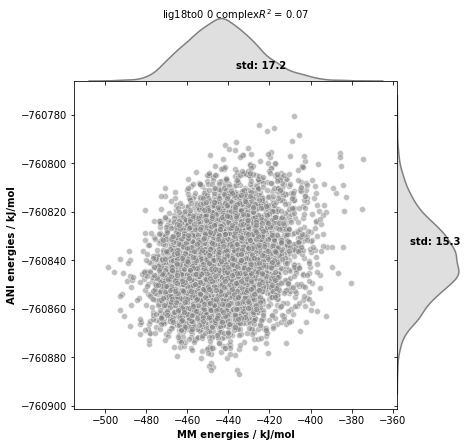

lig17to0
CORRECTION = -9.247868053498678 kcal/mol
ERROR: 1.1565485020682733 kcal/mol



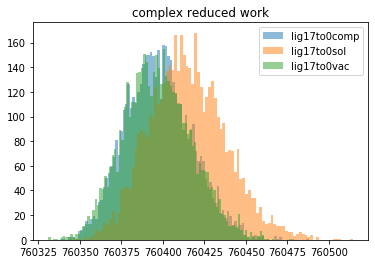

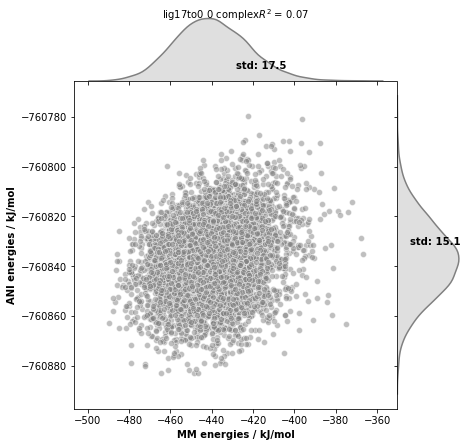

lig1to0
CORRECTION = 259936.52405444917 kcal/mol
ERROR: 1.4089622338182506 kcal/mol



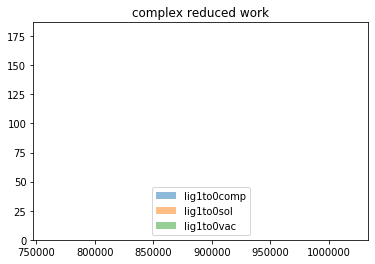

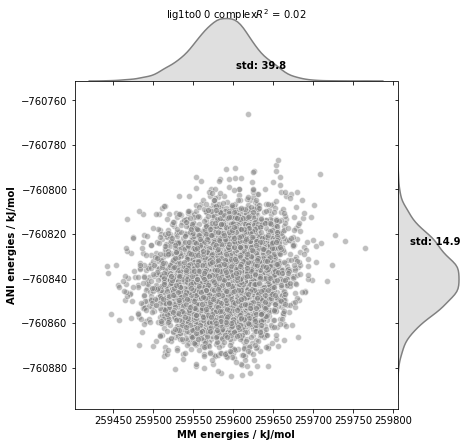


LIGAND 16
lig16to15
CORRECTION = -0.18393326317891479 kcal/mol
ERROR: 1.1006107196268438 kcal/mol



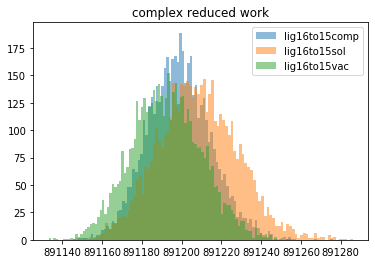

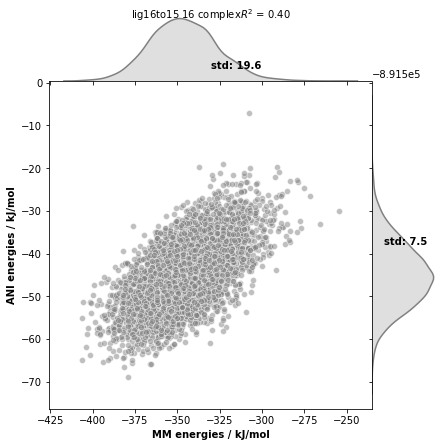

lig14to16
CORRECTION = 979037.547679487 kcal/mol
ERROR: 1.413406725793743 kcal/mol



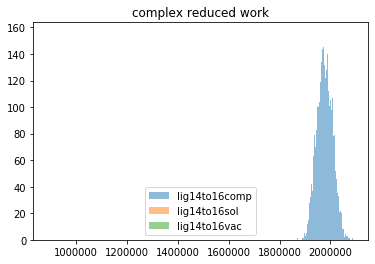

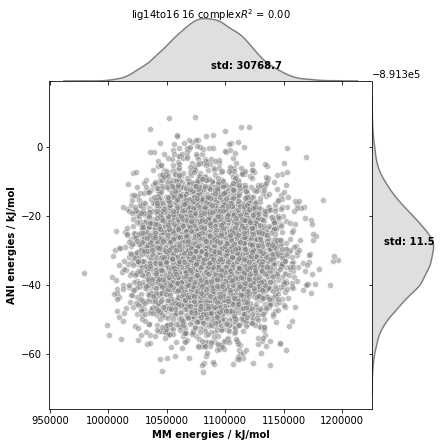

lig16to17
CORRECTION = 4.531550714164041 kcal/mol
ERROR: 0.7824724646180872 kcal/mol



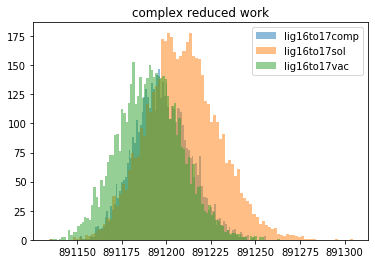

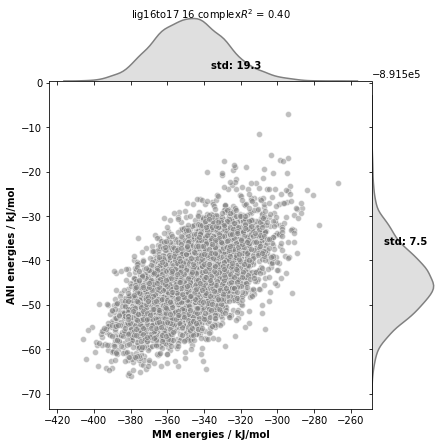

lig16to18
CORRECTION = 0.9837487032637 kcal/mol
ERROR: 1.1578685279446819 kcal/mol



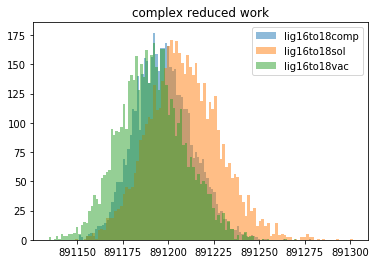

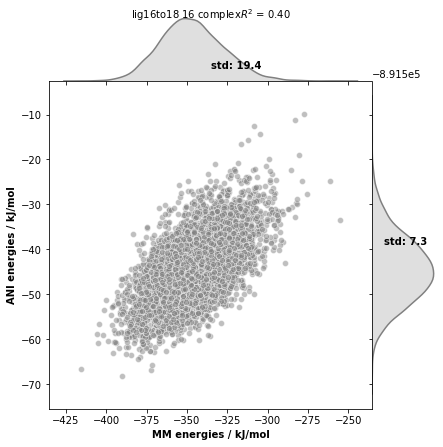


LIGAND 15
lig16to15
CORRECTION = 389790.57634988823 kcal/mol
ERROR: 1.1179859580411324 kcal/mol



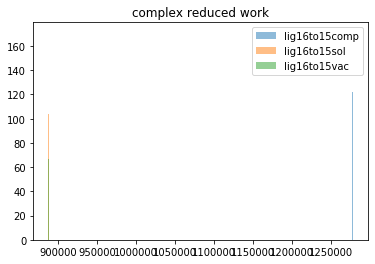

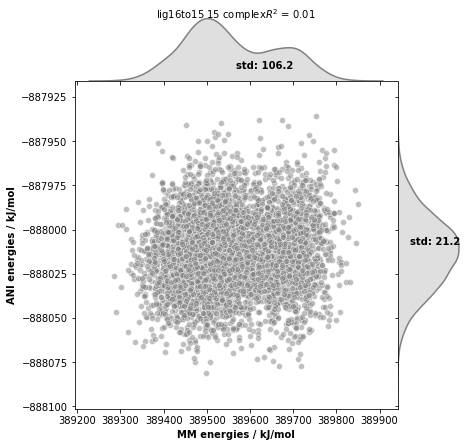

lig10to15
CORRECTION = -9.832452626083978 kcal/mol
ERROR: 1.3859710718913594 kcal/mol



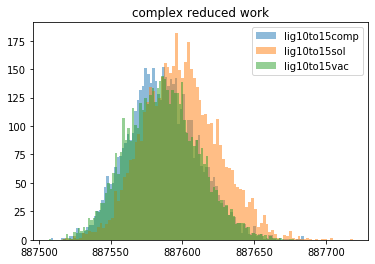

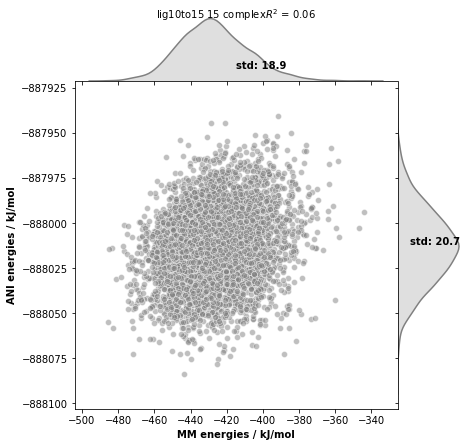

lig14to15
CORRECTION = -6.9326121740741655 kcal/mol
ERROR: 1.1952364174296852 kcal/mol



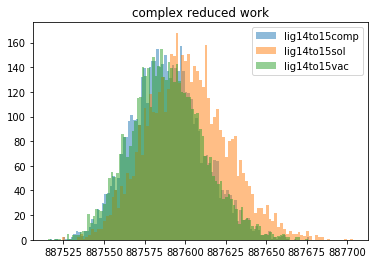

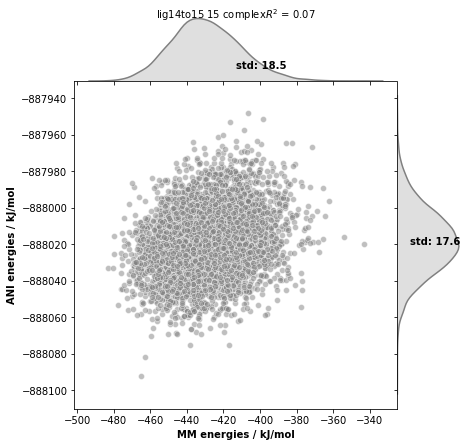

lig15to17
CORRECTION = -9.505533158197068 kcal/mol
ERROR: 0.9968935324185481 kcal/mol



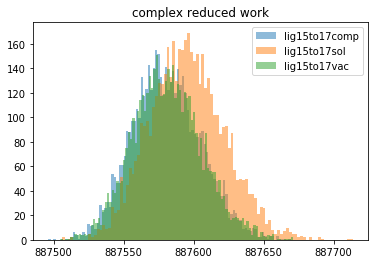

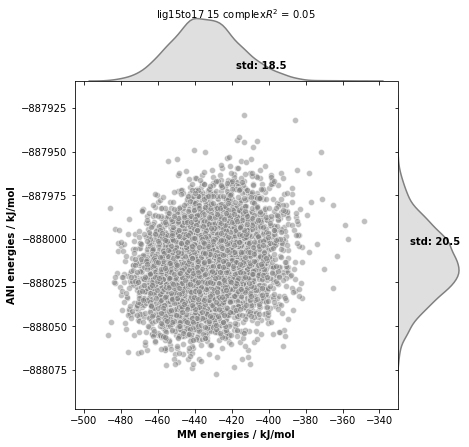


LIGAND 10
lig10to6
CORRECTION = 7.269837594940327 kcal/mol
ERROR: 1.2091585749388647 kcal/mol



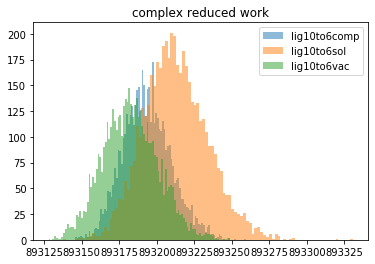

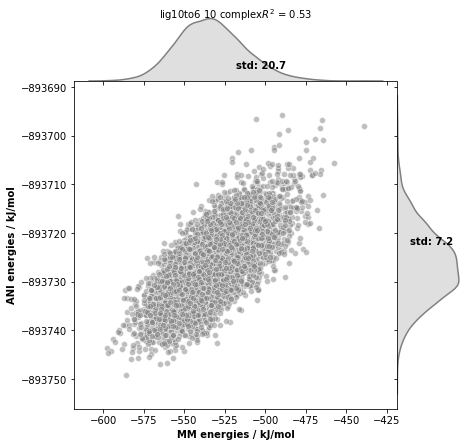

lig10to15
CORRECTION = -8.211951865814626 kcal/mol
ERROR: 1.175488504249203 kcal/mol



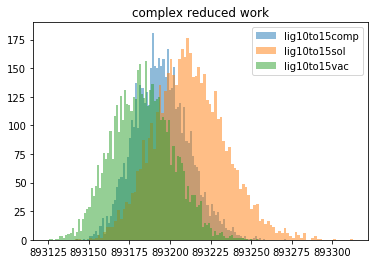

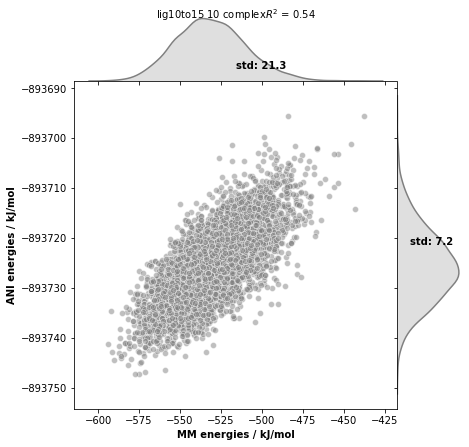

lig9to10
CORRECTION = 6.84254767105449 kcal/mol
ERROR: 0.8866728107051564 kcal/mol



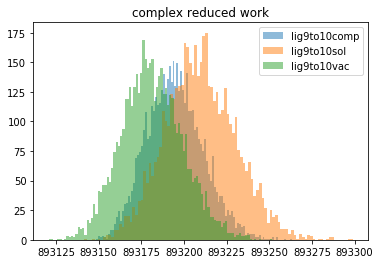

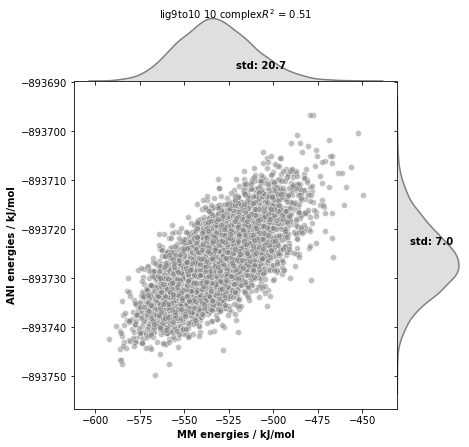

lig10to14
CORRECTION = -6.673042819136754 kcal/mol
ERROR: 1.413977152074034 kcal/mol



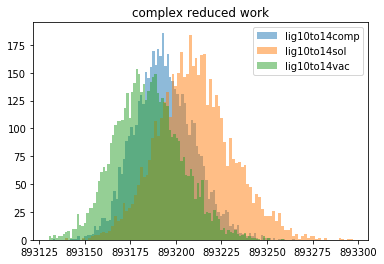

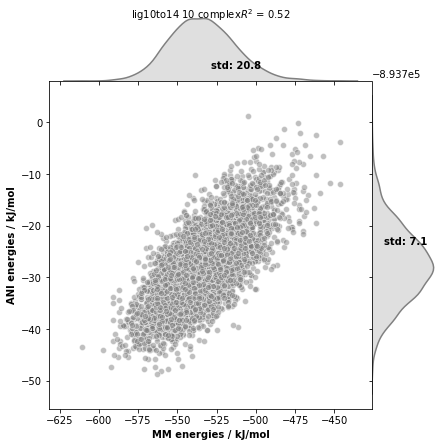


LIGAND 6
lig5to6
CORRECTION = 327319.8468647363 kcal/mol
ERROR: 1.1510143556680439 kcal/mol



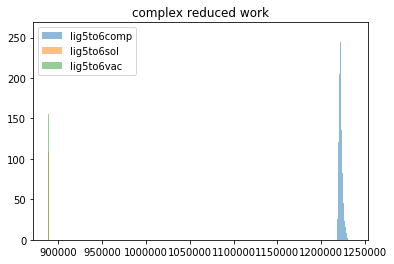

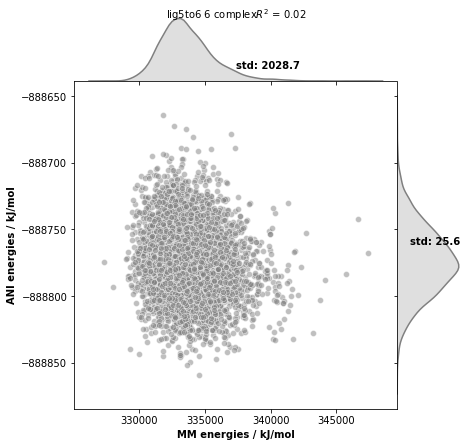

lig10to6
CORRECTION = 895449.7293192844 kcal/mol
ERROR: 0.8867975988434739 kcal/mol



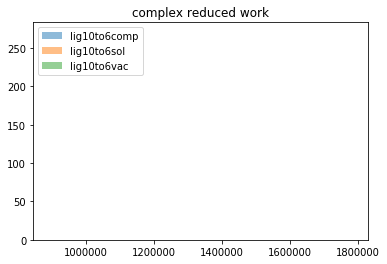

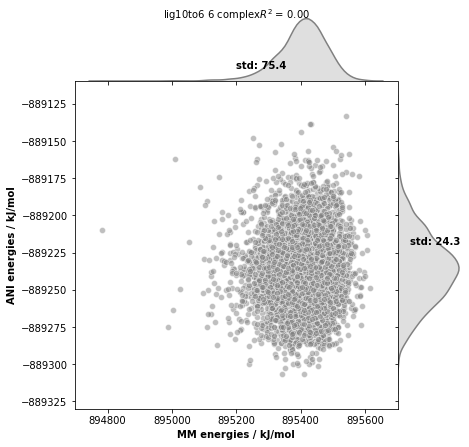

lig4to6
CORRECTION = -11.34429429017473 kcal/mol
ERROR: 0.9094020624931937 kcal/mol



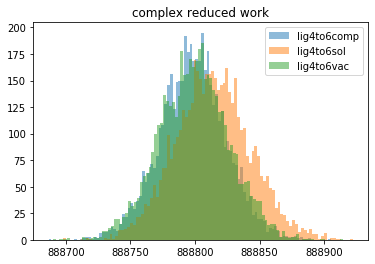

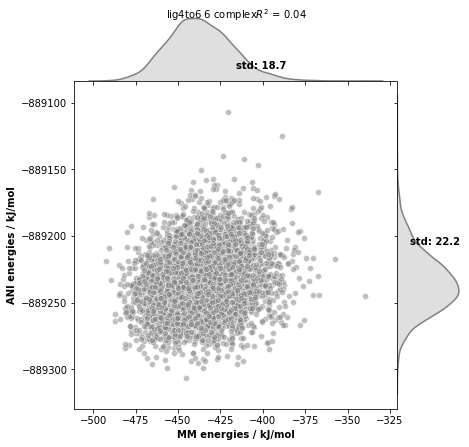

lig9to6
CORRECTION = -18.179313790868036 kcal/mol
ERROR: 1.347204083257901 kcal/mol



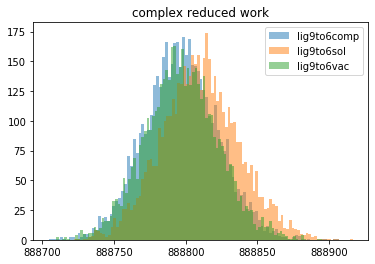

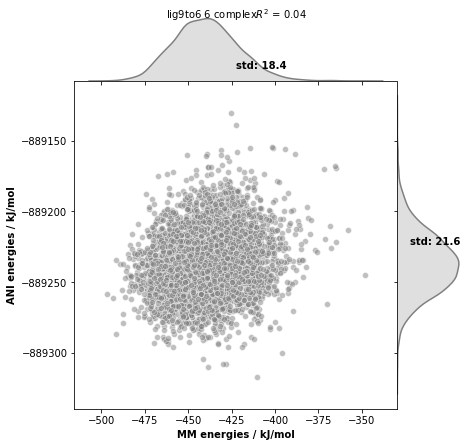


LIGAND 9
lig5to9
CORRECTION = 740357.1171381612 kcal/mol
ERROR: 1.0345801428647112 kcal/mol



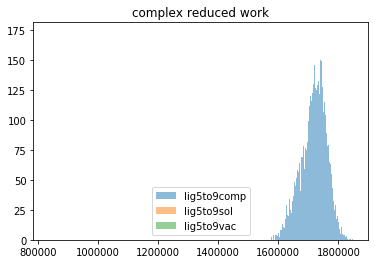

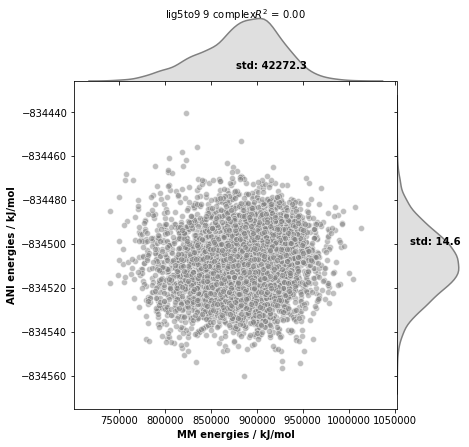

lig9to14
CORRECTION = -2.870975081343204 kcal/mol
ERROR: 0.7180505817007273 kcal/mol



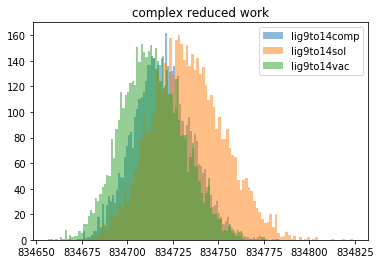

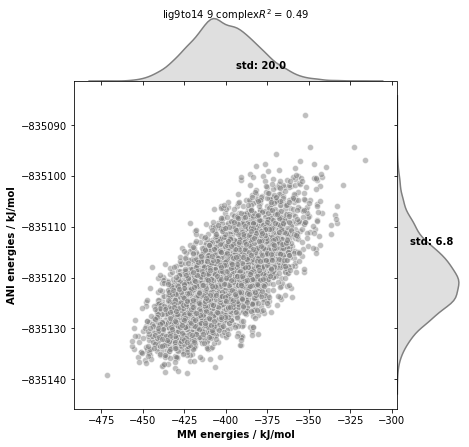

lig9to10
CORRECTION = -5.086014383705333 kcal/mol
ERROR: 1.2176602984714382 kcal/mol



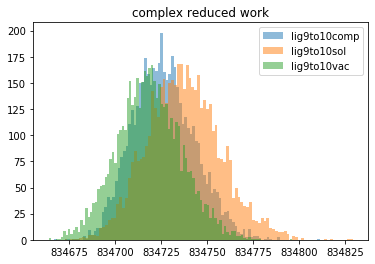

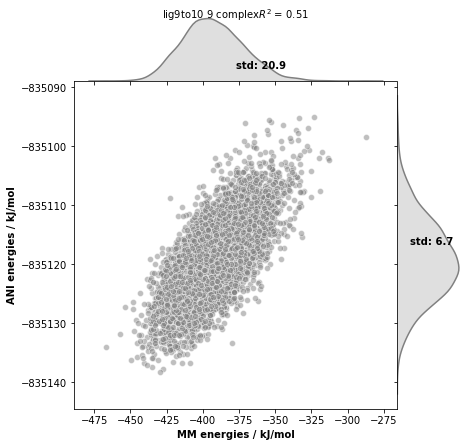

lig9to6
CORRECTION = -2.4834833170752972 kcal/mol
ERROR: 0.6962545727831063 kcal/mol



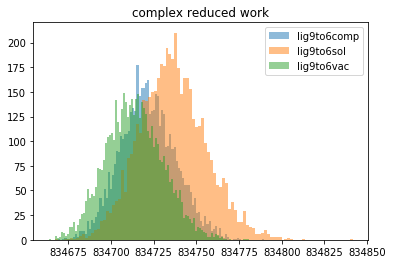

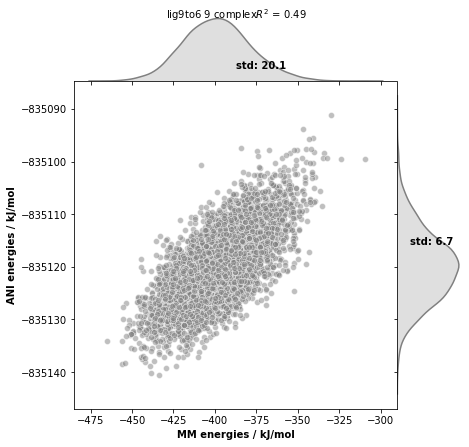


LIGAND 2
lig0to2
CORRECTION = -14.291877692914568 kcal/mol
ERROR: 0.8718130666555977 kcal/mol



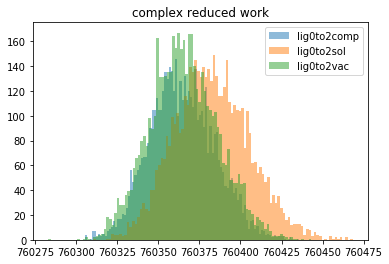

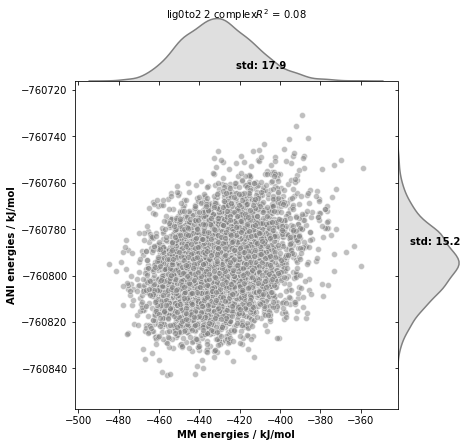

lig2to5
CORRECTION = -8.662640695576556 kcal/mol
ERROR: 0.8148713583933893 kcal/mol



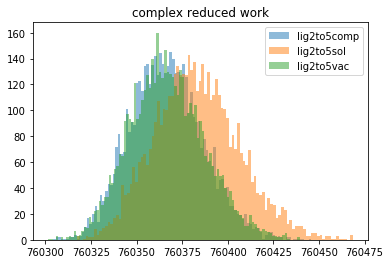

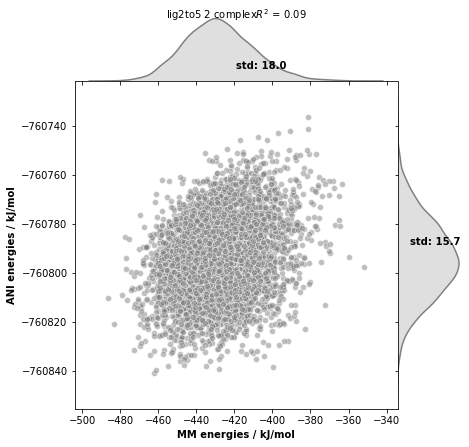

lig2to4
CORRECTION = -9.427103818277828 kcal/mol
ERROR: 0.7976871000353413 kcal/mol



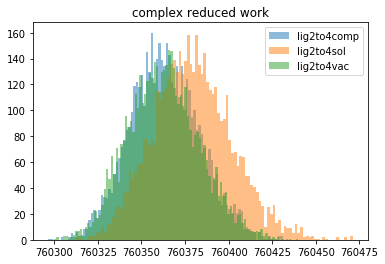

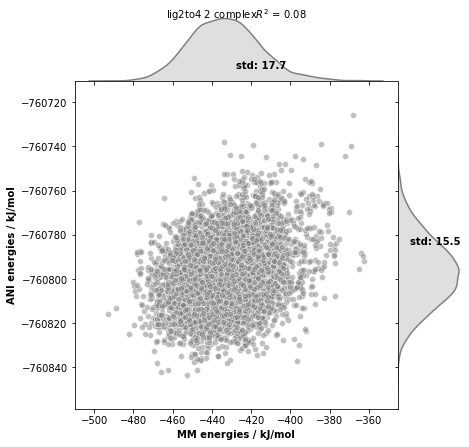

lig1to2
CORRECTION = -13.073987431707792 kcal/mol
ERROR: 1.115761782235528 kcal/mol



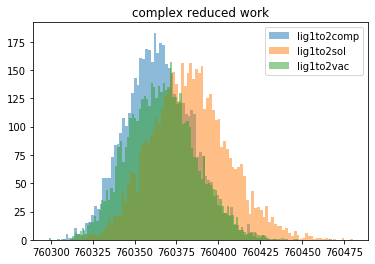

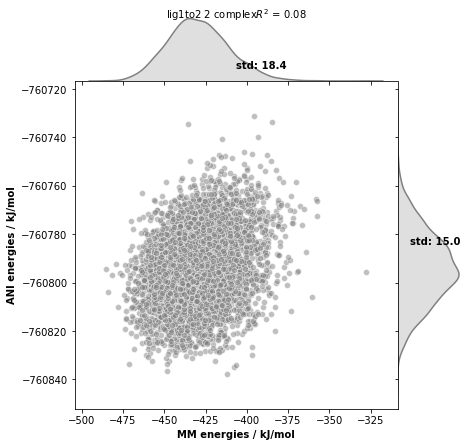


LIGAND 4
lig1to4
CORRECTION = -22.6621846917551 kcal/mol
ERROR: 1.1489737731826768 kcal/mol



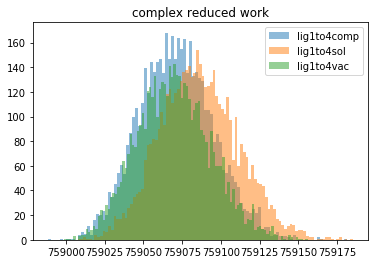

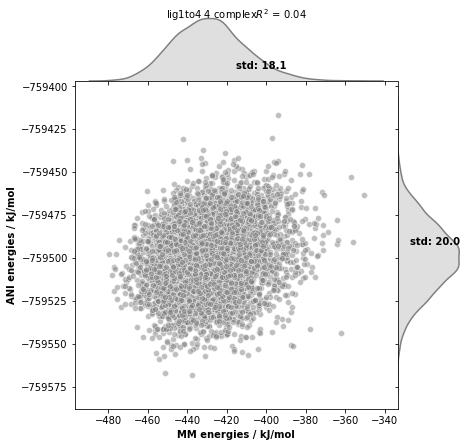

lig4to5
CORRECTION = -7.080993290175684 kcal/mol
ERROR: 1.2283095018465597 kcal/mol



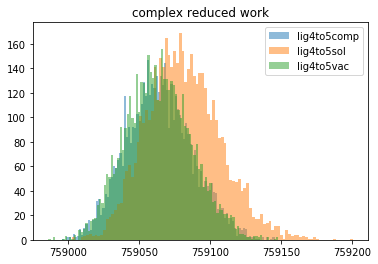

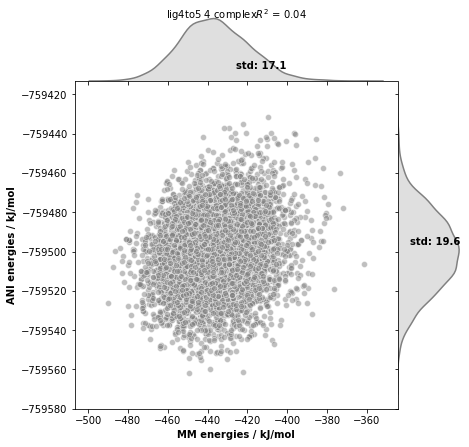

lig2to4
CORRECTION = -13.608973900321871 kcal/mol
ERROR: 0.9781720813913748 kcal/mol



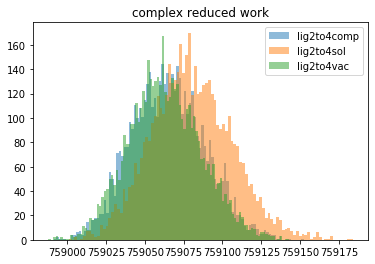

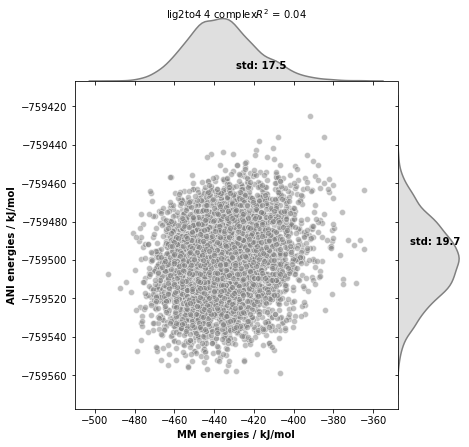

lig4to6
CORRECTION = -26.028715823427774 kcal/mol
ERROR: 0.8933496210569498 kcal/mol



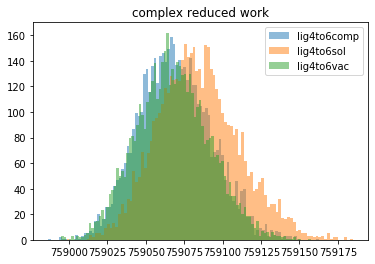

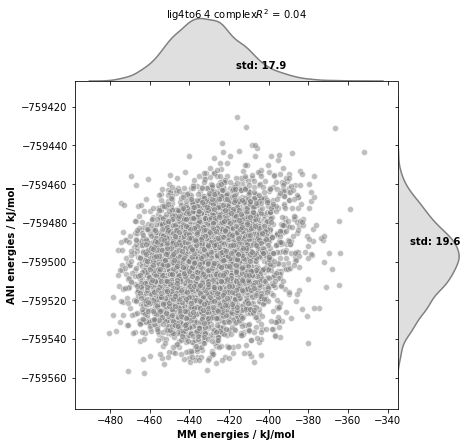


LIGAND 5
lig4to5
CORRECTION = -12.115444698603824 kcal/mol
ERROR: 1.1368467975706165 kcal/mol



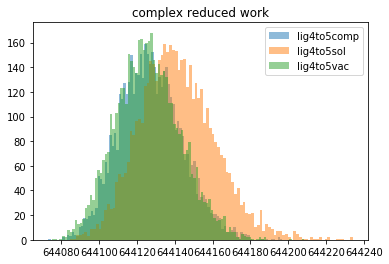

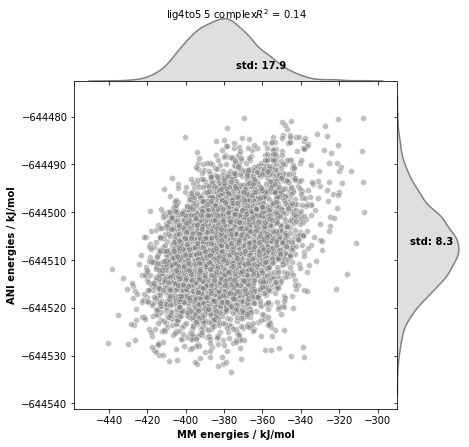

lig5to6
CORRECTION = -11.288118867669255 kcal/mol
ERROR: 1.1201037374027598 kcal/mol



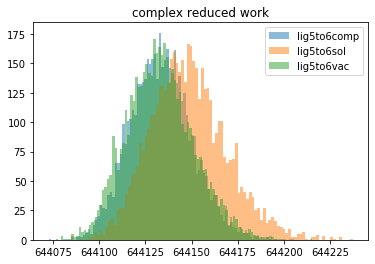

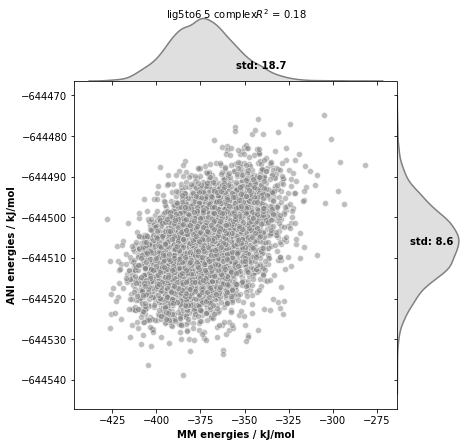

lig2to5
CORRECTION = -1.4268416981212795 kcal/mol
ERROR: 0.5496569692459619 kcal/mol



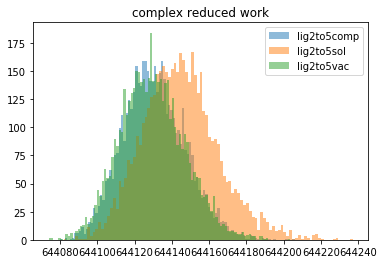

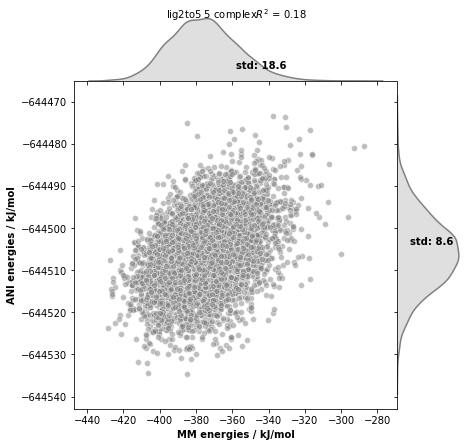

lig5to9
CORRECTION = -16.74143295257818 kcal/mol
ERROR: 1.0263832664565258 kcal/mol



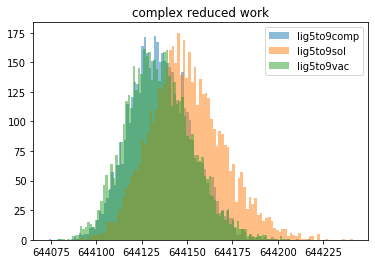

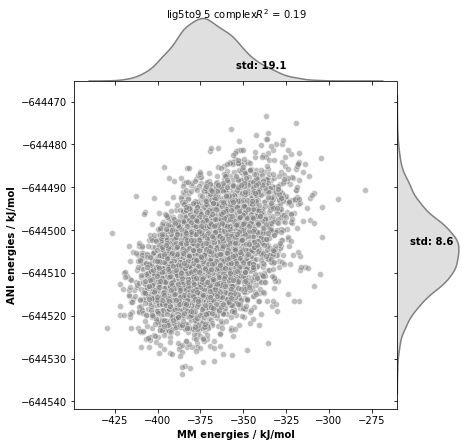


LIGAND 14
lig14to16
CORRECTION = 1.8577845133841038 kcal/mol
ERROR: 1.414061581478744 kcal/mol



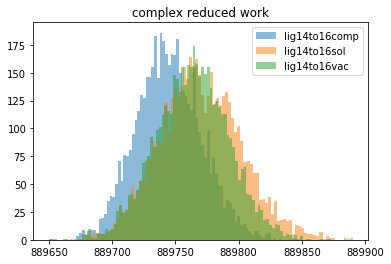

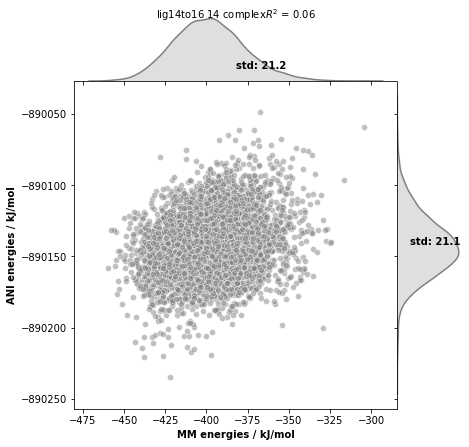

lig9to14
CORRECTION = 0.880889346706681 kcal/mol
ERROR: 1.4140428815531625 kcal/mol



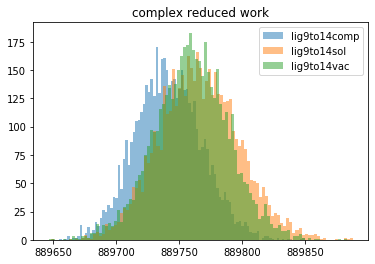

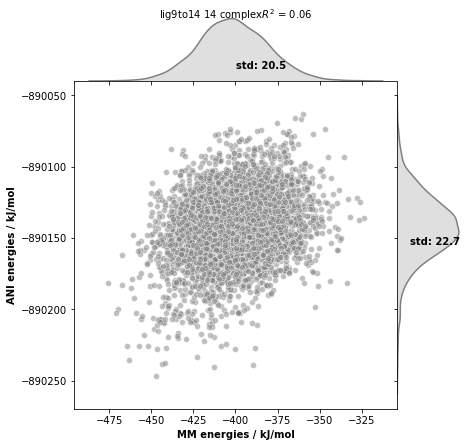

lig14to15
CORRECTION = -24.221893794485368 kcal/mol
ERROR: 1.1966538763276495 kcal/mol



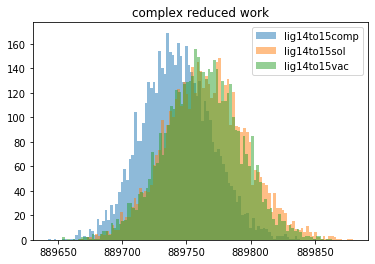

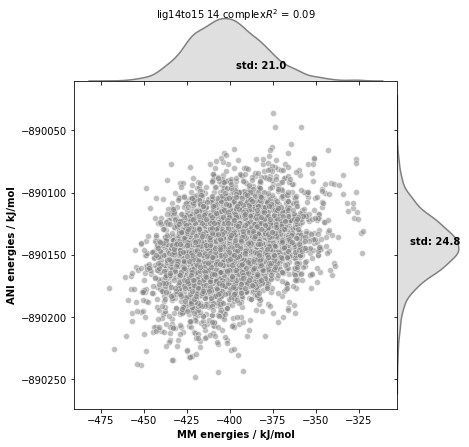

lig10to14
CORRECTION = -3.184467810904607 kcal/mol
ERROR: 1.0095640791553169 kcal/mol



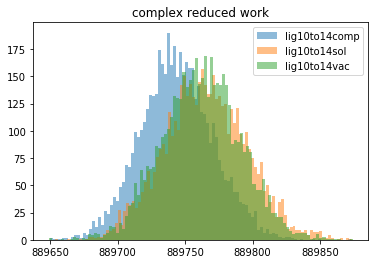

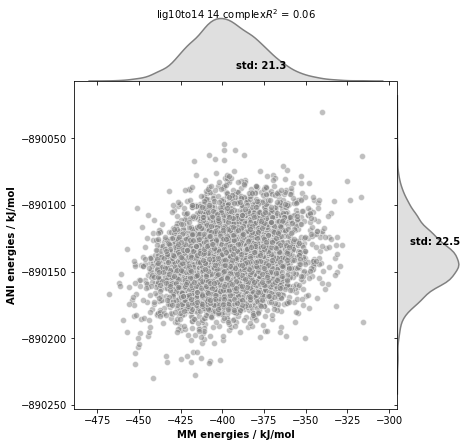


LIGAND 17
lig16to17
CORRECTION = 992.8591659911908 kcal/mol
ERROR: 1.1544279294271564 kcal/mol



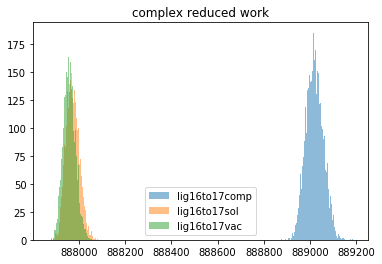

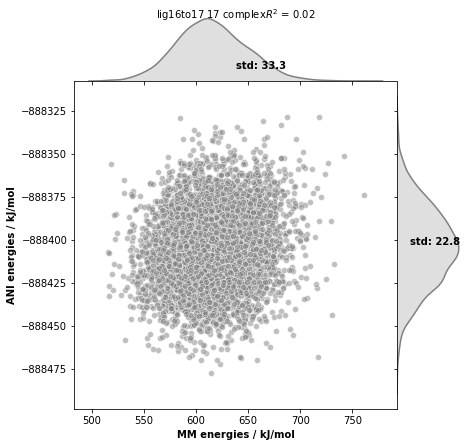

lig17to0
CORRECTION = -7.870604548836127 kcal/mol
ERROR: 1.217484028584122 kcal/mol



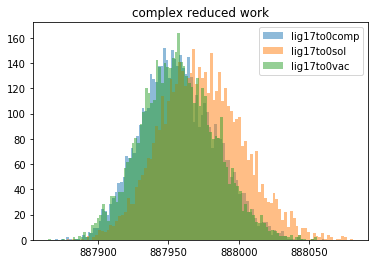

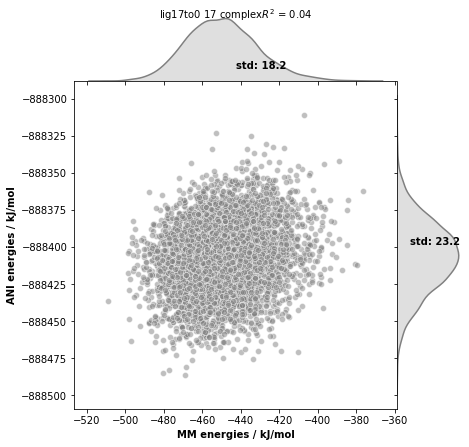

lig15to17
CORRECTION = 296607.33079776424 kcal/mol
ERROR: 1.117842467621395 kcal/mol



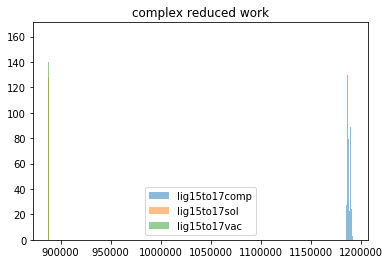

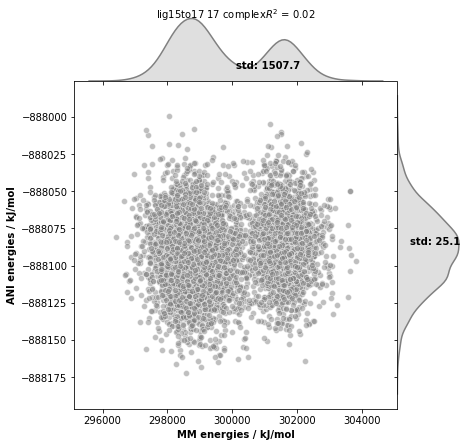

lig17to18
CORRECTION = -10.952411867678165 kcal/mol
ERROR: 1.1346315784596104 kcal/mol



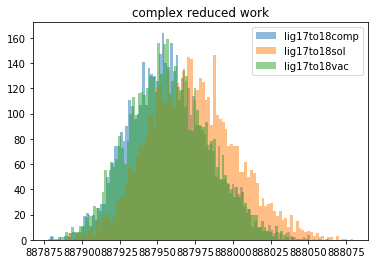

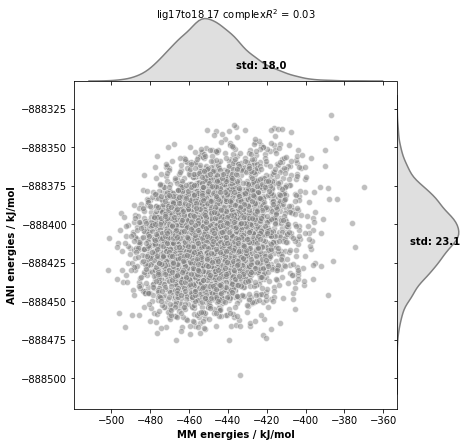


LIGAND 18
lig18to0
CORRECTION = 6.268137247534469 kcal/mol
ERROR: 1.2215762165104969 kcal/mol



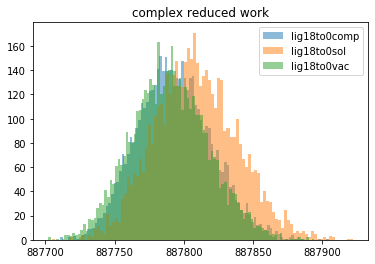

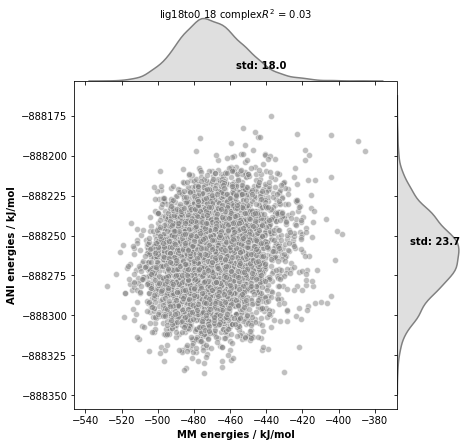

lig18to1
CORRECTION = 10.57762768783141 kcal/mol
ERROR: 0.8636463768367513 kcal/mol



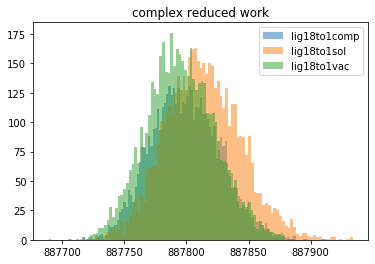

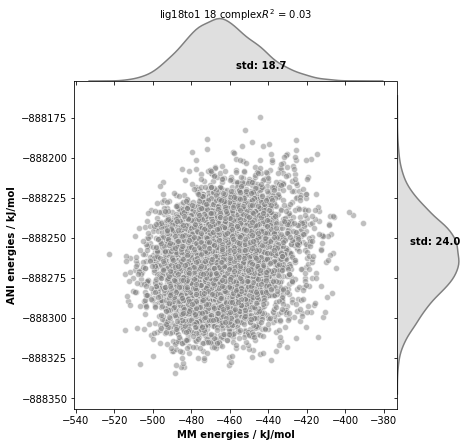

lig16to18
CORRECTION = 120771.62794926926 kcal/mol
ERROR: 1.1562435677400549 kcal/mol



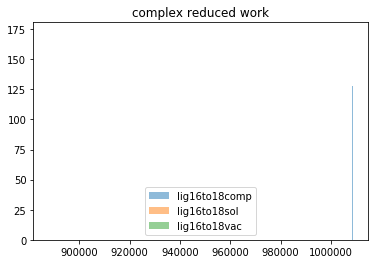

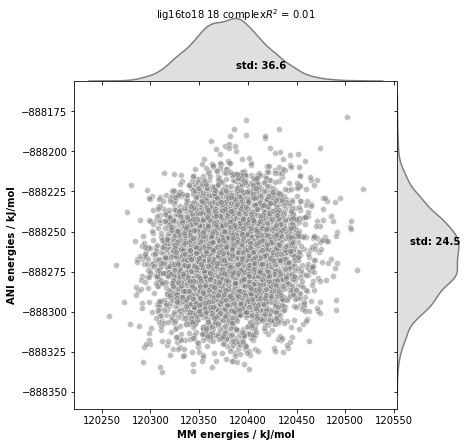

lig17to18
CORRECTION = -19.093217959743924 kcal/mol
ERROR: 1.1518438127442256 kcal/mol



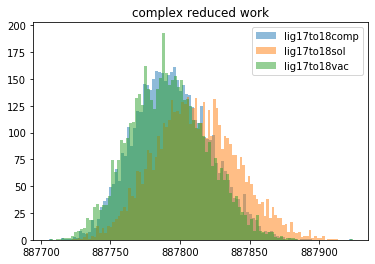

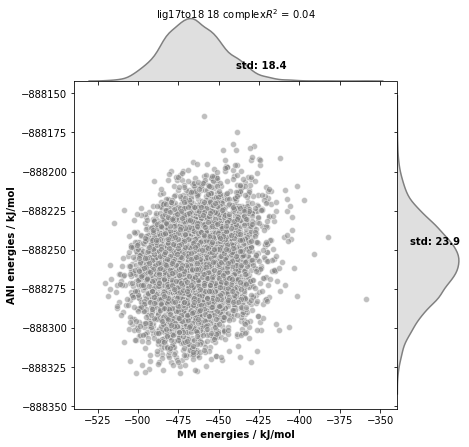

In [34]:
import copy

n_bootstrap = 1000

for node in G.nodes(data=True):
    print(f'LIGAND {node[0]}')
    results = copy.deepcopy(node[1]['results']) 
    node[1]['corrections'] = []
    node[1]['corrections_errs'] = []

    # check the overlap in the energies from different edges
    # stats.f_oneway(data_group1, data_group2, data_group3, data_groupN)

    # shift all the MM results closer to zero
    all_MM_results = [x for x in results.keys() if '_MM' in x]
#         normalise_MM = normalise_energies([results[x] for x in all_MM_results])
#         for x, shifted in zip(all_MM_results, normalise_MM):
#             results[x] = shifted

    # shift all the MM results closer to zero
    all_ANI_results = [x for x in results.keys() if '_ANI' in x]
#         normalise_ANI = normalise_energies([results[x] for x in all_ANI_results])
#         for x, shifted in zip(all_ANI_results, normalise_ANI):
#             results[x] = shifted

    edges = set([x.split('_')[0] for x in results.keys()])
    all_edges_complex_corrections = []
    for edge in edges:
        print(edge)
        complex_reduced_work = results[edge+'_complex_MM'] - results[edge+'_complex_ANI']
        solvent_reduced_work = results[edge+'_solvent_MM'] - results[edge+'_solvent_ANI']
        vacuum_reduced_work = results[edge+'_vacuum_MM'] - results[edge+'_vacuum_ANI']

        complex_corrections = []
        solvent_corrections = []
        vacuum_corrections = []
        for i in range(n_bootstrap):
            complex_correction = EXP(np.random.choice(complex_reduced_work[1:],len(complex_reduced_work)))
            solvent_correction = EXP(np.random.choice(solvent_reduced_work[1:],len(complex_reduced_work)))
            vacuum_correction = EXP(np.random.choice(solvent_reduced_work[1:],len(complex_reduced_work)))
            complex_corrections.append(complex_correction[0])
            solvent_corrections.append(solvent_correction[0])
            node[1]['corrections'].append(complex_correction[0] - solvent_correction[0])
            node[1]['corrections_errs'].append((complex_correction[1]**2 + solvent_correction[1]**2)**0.5)
        print(f'CORRECTION = {(complex_correction[0] - solvent_correction[0]) * unit.kilocalorie_per_mole}')
        print(f'ERROR: {(complex_correction[1]**2 + solvent_correction[1]**2)**0.5 * unit.kilocalorie_per_mole}')
        print()

        all_edges_complex_corrections.append(complex_corrections)
        plt.title('complex reduced work')
        plt.hist(complex_reduced_work[1:],bins=100, label=f'{edge}comp',alpha=0.5)
        plt.hist(solvent_reduced_work[1:],bins=100, label=f'{edge}sol',alpha=0.5)
        plt.hist(vacuum_reduced_work[1:],bins=100, label=f'{edge}vac',alpha=0.5)
        plt.legend()
#         print(EXP(complex_reduced_work[1:])[0])
#         print(EXP(complex_reduced_work[1:])[0])
#             plt.show()
#             plt.hist(results[edge+'_complex_MM'],label='complex MM',bins=100)
# #             plt.hist(results[edge+'_solvent_MM'],label='solvent MM',bins=100)
# #             plt.legend()
# #             plt.title(edge)
# #             plt.show()

#             plt.hist(results[edge+'_complex_ANI'],label='complex ANI',bins=100)
# #             plt.hist(results[edge+'_solvent_ANI'],label='solvent ANI',bins=100)
#             plt.legend()
#             plt.title(edge)
#             plt.show()

        plot_mm_vs_ani(results[edge+'_complex_MM'][1:],results[edge+'_complex_ANI'][1:],title=f'{edge} {node[0]} complex')
#         plot_mm_vs_ani(results[edge+'_solvent_MM'][1:],results[edge+'_solvent_ANI'][1:],title=f'{edge} {node[0]} solvent')
    plt.show()
    print()


In [32]:
print(5)

5


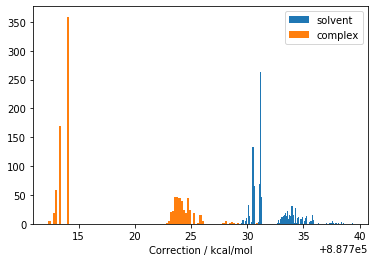

In [13]:
plt.hist(solvent_corrections,bins=100,label='solvent')
plt.hist(complex_corrections,bins=100,label='complex')
plt.xlabel(f'Correction / kcal/mol')
plt.legend()
plt.show()

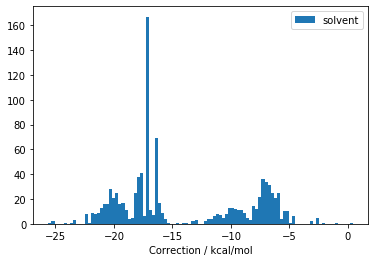

In [14]:
plt.hist([i-j for i,j in zip(complex_corrections,solvent_corrections)],bins=100,label='solvent')
# plt.hist(complex_corrections,bins=100,label='complex')
plt.xlabel(f'Correction / kcal/mol')
plt.legend()
plt.show()

In [15]:
F = nx.DiGraph()

for node in G.nodes(data=True):
    # leave behind the context
    F.add_node(node[0],**{x:node[1][x] for x in node[1].keys() if x != 'context'})
    
for edge in G.edges(data=True):
    F.add_edge(edge[0],edge[1])

In [16]:
import pickle
with open('TheBeast.pi', 'wb') as f:
    pickle.dump(F, f)

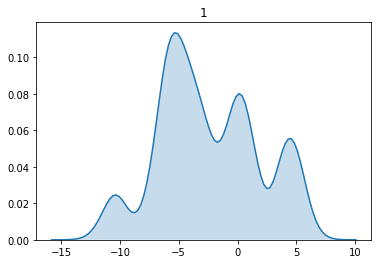

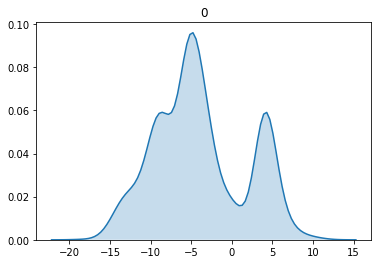

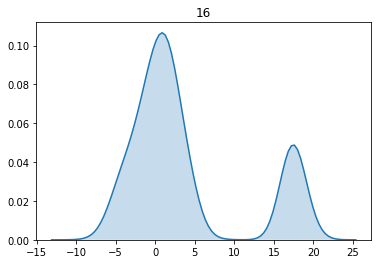

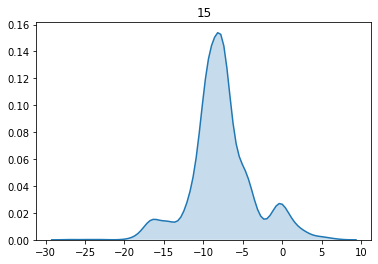

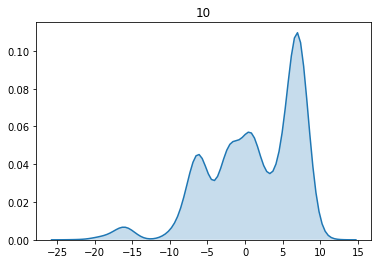

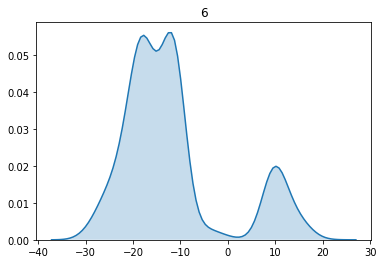

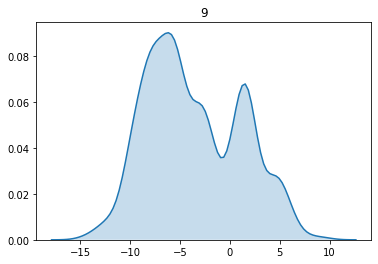

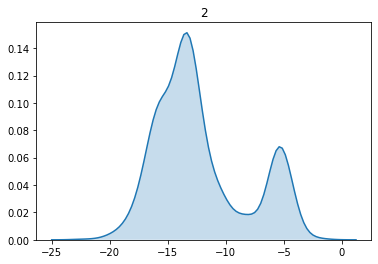

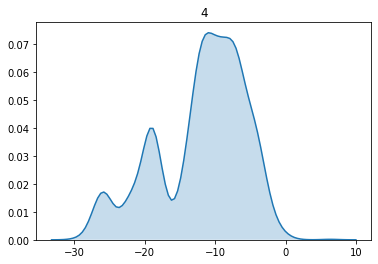

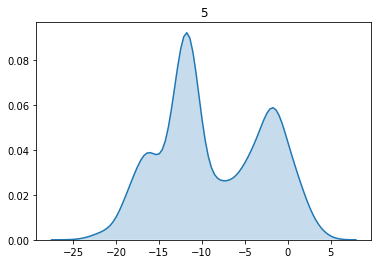

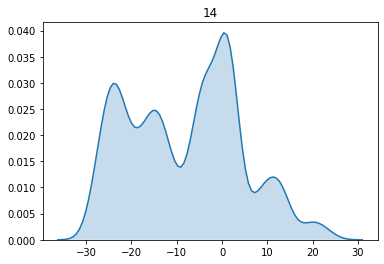

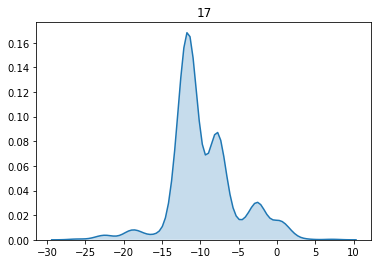

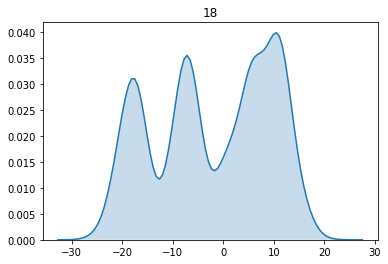

In [88]:
shifts = []

for node in G.nodes(data=True):
    values = sorted([(i * unit.kilocalorie_per_mole)._value for i in node[1]['corrections'] if np.abs(i) < 30])
    sns.kdeplot(values,shade=True)
#     print(values[-1])
    shifts.append((values[int(len(values)/2)], np.std(values)))
    plt.title(node[0])
    plt.show()

In [85]:
# TODO - closer to experiment or not?

In [86]:
print(shifts)

[(-3.142996586742811, 4.305437316493994), (-4.738948434591293, 5.577144617901173), (1.2575604618759826, 7.400595593996231), (-7.9317670210730284, 3.9608873710308625), (1.489646395551972, 5.9631337364826535), (-14.014603692223318, 10.919651111649356), (-4.689609304070473, 4.717559181514592), (-13.227406407007948, 3.956290824514406), (-10.825452943099663, 6.274909879885738), (-10.536977397161536, 6.083395941820762), (-5.319448741269298, 12.414039630992223), (-10.836111682234332, 4.267065602437595), (0.13433552102651447, 11.372997168067378)]


In [30]:
# TODO check if the correction is the same for each edge of the same node (it should be)

In [76]:
import importlib
import sys
import freeenergyframework
importlib.reload(sys.modules['freeenergyframework'])

network = freeenergyframework.wrangle.FEMap('/Users/brucemah/bin/relative-paper/perses050_repeat/Jnk1-openff-1.0.0.csv')
freeenergyframework.plotting.plot_DDGs(network.results, title=f'{file.split("-")[0]} {file.split("-",1)[1][:-4]}', filename=f'{file[0:-4]}DDGs.png')
freeenergyframework.plotting.plot_DGs(network.graph, title=f'{file.split("-")[0]} {file.split("-",1)[1][:-4]}', filename=f'{file[0:-4]}DGs.png')
plt.show()

AttributeError: module 'freeenergyframework' has no attribute 'wrangle'